# Setup

In [1]:
!rm *.csv # Removendo dados anteriores
!rm -R figs # Removendo pasta de figuras
!rm -R tabs # Removendo pasta de tabelas
!mkdir figs # Criando pasta para salvar figuras
!mkdir tabs # Criando pasta para salvar tabelas
!ls

Benchmark.html	 Benchmark.Rmd	figs		       tabs
Benchmark.ipynb  Clean.ipynb	SeriesTemporais.Rproj


# Introdução

Esta rotina ajusta um modelo de séries temporais. 
Será testado se o investimento residencial ($I_h$) depende da <u>taxa própria de juros</u> dos imóveis, ou seja,

$$
I_h = f(r_{mo}, p_h)
$$
em que

- $I_h$ Investimento residencial

  + **Série:** PRFI
  + Com ajuste sazonal
  + Trimestral
  
- $r_{mo}$ taxa de juros das hipotecas
  + **Série:** MORTGAGE30US
  - Sem ajuste sazonal
  - Semanal (encerrado às quintas feiras)

- $p_h$ Inflação de imóveis: Índice Case-Shiller

  + **Série:** CSUSHPISA
  + Com ajuste sazonal, Jan 2000 = 100
  + Mensal
  
**Nota:** Uma vez que pretende-se utilizar os resultados obtidos deste modelo em um trabalho futuro, os resultados serão checados tanto em python quanto em gretl, ambos softwares livres.

# Carregando pacotes

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext rpy2.ipython

# Pacotes gerais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
# Pacotes estatísticos

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.api import SVAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, CointRankResults, VECM, select_coint_rank

from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_arch, het_breuschpagan, het_white
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, q_stat, coint
from arch.unitroot import PhillipsPerron, ZivotAndrews, DFGLS, KPSS, ADF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pacotes para importação de dados

import pandas_datareader.data as web
from scipy.stats import yeojohnson

# Configurações do notebook

plt.style.use('seaborn-white')
start = datetime.datetime(1987, 1, 1)
end = datetime.datetime(2019, 7, 1)

In [3]:
%%R
library(strucchange)
library(urca)

R[write to console]: Carregando pacotes exigidos: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Carregando pacotes exigidos: sandwich



In [4]:
def testes_raiz(df, original_trend='c', diff_trend='c'):
    """
    serie: Nome da coluna do df
    orignal_trend: 'c', 'ct', 'ctt'
    diff_trend: 'c', 'ct', 'ctt'
    
    Plota série o original e em diferenta e retorna testes de raíz unitária
    """
    fig, ax = plt.subplots(1,2)

    df.plot(ax=ax[0], title='série original')
    df.diff().plot(ax=ax[1], title='série em diferença')

    plt.tight_layout()
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots(2,2)
    
    plot_acf(df, ax=ax[0,0], title='ACF: serie original') 
    plot_pacf(df, ax=ax[0,1], title='PACF: serie original')
    
    plot_acf(df.diff().dropna(), ax=ax[1,0], title='ACF: serie em diferença') 
    plot_pacf(df.diff().dropna(), ax=ax[1,1], title='PACF: serie em diferença')
    
    plt.tight_layout()
    sns.despine() 
    plt.show()

    
    # Zivot Andrews
    print('\nZIVOT ANDREWS')
    print(ZivotAndrews(df, trend = original_trend).summary(),"\n")
    print(ZivotAndrews(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nADF')
    print(ADF(df, trend=original_trend).summary(),"\n")
    print(ADF(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nDFGLS')
    print(DFGLS(df, trend=original_trend).summary(),"\n")
    print(DFGLS(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nKPSS')
    print(KPSS(df, trend = original_trend).summary(),"\n")
    print(KPSS(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nPhillips Perron')
    print(PhillipsPerron(df, trend=original_trend).summary(),"\n")
    print(PhillipsPerron(df.diff().dropna(), trend=diff_trend).summary(),"\n")

In [5]:
def cointegracao(ts0, ts1, signif = 0.05, lag=5):
  trends = ['nc', 'c', 'ct', 'ctt']  
  print("\nENGEL-GRANGER TEST\n")
  for trend in trends:
    print(f'Testing trend = {trend}\n')
    result = coint(ts0, ts1, trend = trend, maxlag=lag)
    print('Null Hypothesis: there is NO cointegration')
    print('Alternative Hypothesis: there IS cointegration')
    print('t Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] < signif:
        print('CONCLUSION: REJECT null Hypothesis: there IS cointegration\n')
    else:
        print('CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration\n')

In [6]:
def LjungBox_Pierce(resid, signif = 0.05, boxpierce = False, k = 4):
  """
  resid = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: autocorrelations up to lag k equal zero")
  print('H1: autocorrelations up to lag k not zero')
  print("Box-Pierce: ", boxpierce)
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper(), ". Considering a significance level of",  signif*100,"%")
    result = acorr_ljungbox(x = resid.iloc[:,i-1], lags = k, boxpierce = boxpierce)[i-1] < signif
    for j in range(k):
      print("Reject H0 on lag " ,j+1,"? ", result[j])
    print("\n")
    
def ARCH_LM(resid, signif = 0.05, autolag = 'bic'):
  """
  df = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: Residuals are homoscedastic")
  print('H1: Residuals are heteroskedastic')
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper())
    result = het_arch(resid = resid.iloc[:,i], autolag = autolag)
    print('LM p-value: ', result[1])
    print("Reject H0? ", result[1] < signif)
    print('F p-value: ', result[3])
    print("Reject H0? ", result[3] < signif)
    print('\n')
    

def analise_residuos(results, nmax=15):
    
    residuals = pd.DataFrame(results.resid, columns = results.names)
    
    residuals.plot()
    sns.despine()
    plt.show()
    
    print('AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU\n')
    print(results.test_whiteness(nlags=nmax).summary())
    print('\nAUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO\n')
    print(results.test_whiteness(nlags=nmax, adjusted=True).summary())
    print('\nLJUNGBOX\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=False)
    print('\nBOXPIERCE\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=True)
    print('\nNORMALIDADE\n')
    print(results.test_normality().summary())
    print('\nHOMOCEDASTICIDADE\n')
    ARCH_LM(residuals)
    
    return residuals
    

# Importando dados

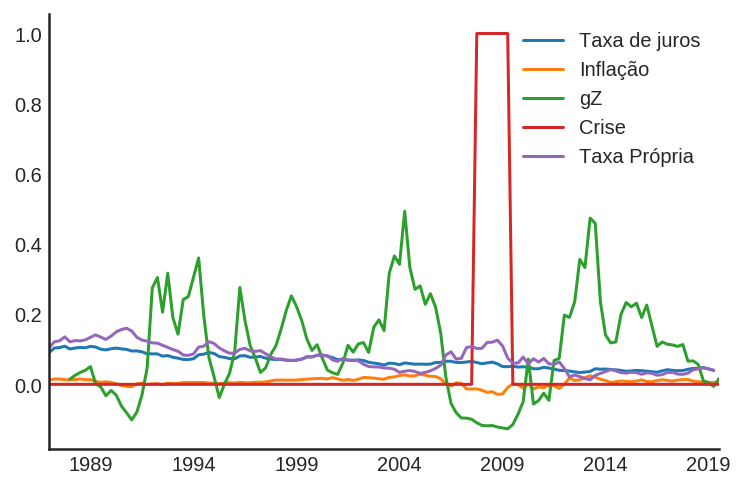

,Taxa de juros,Inflação,gZ,Crise,Taxa Própria,d_Taxa Própria,d_gZ,d_Inflação,d_Taxa de juros
,,,,,,,,,
2018-06-30,0.045446,0.009007,0.066893,0,0.041386,0.009454,0.001012,-0.004757,0.002623
2018-09-30,0.045669,0.007121,0.056555,0,0.044225,0.002839,-0.010338,-0.001885,0.000223
2018-12-31,0.047846,0.007440,0.009721,0,0.046668,0.002443,-0.046833,0.000318,0.002177
2019-03-31,0.043738,0.005347,0.004754,0,0.044109,-0.002559,-0.004968,-0.002093,-0.004108
2019-06-30,0.040108,0.005519,-0.006007,0,0.039164,-0.004945,-0.010761,0.000172,-0.003631


In [7]:
df = web.DataReader(
    [
        "PRFI",
        "CSUSHPISA",
        "MORTGAGE30US",
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    "Investimento residencial", 
    "Preço dos imóveis", 
    "Taxa de juros",
]
df.index.name = ""

df['Taxa de juros'] = df['Taxa de juros'].divide(100)
df['Preço dos imóveis'] = df['Preço dos imóveis']/df['Preço dos imóveis'][0]
df["Inflação"] = df["Preço dos imóveis"].pct_change(12)
df = df.resample('Q').mean()

df["Taxa Própria"] = ((1+df["Taxa de juros"])/(1+df["Inflação"])) -1
df['Taxa Própria'], *_ = yeojohnson(df['Taxa Própria'])

df['gZ'], *_ = yeojohnson(df["Investimento residencial"].pct_change(4))

df["Crise"] = [0 for i in range(len(df["gZ"]))]
for i in range(len(df["Crise"])):
    if df.index[i] > datetime.datetime(2007,12,1) and df.index[i] < datetime.datetime(2009,7,1):
        df["Crise"][i] = 1

df.to_csv("Dados_yeojohnson.csv", )

df = df[["Taxa de juros", "Inflação", "gZ", "Crise", "Taxa Própria"]]
df.plot()
sns.despine()
plt.show()

df["d_Taxa Própria"] = df["Taxa Própria"].diff()
df["d_gZ"] = df["gZ"].diff()
df["d_Inflação"] = df["Inflação"].diff()
df["d_Taxa de juros"] = df['Taxa de juros'].diff()
df = df.dropna()
df.tail()

# Teste de raíz unitária

## Investimento residencial ($g_Z$)

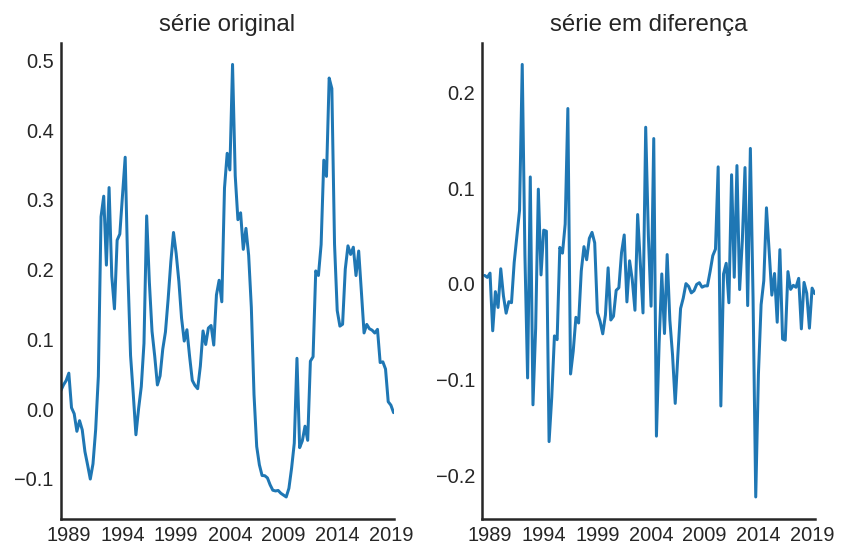

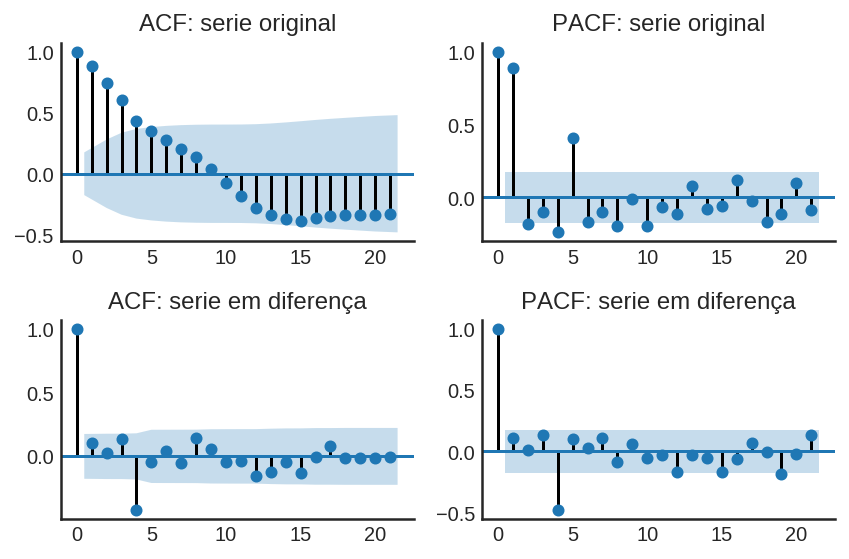


ZIVOT ANDREWS
        Zivot-Andrews Results        
Test Statistic                 -3.934
P-value                         0.392
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -7.919
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.312
P-value                         0.014
Lags                                7
------

In [8]:
testes_raiz(df=df['gZ'])

**Conclusão:** Série é fracamente estacionária.

## Taxa própria

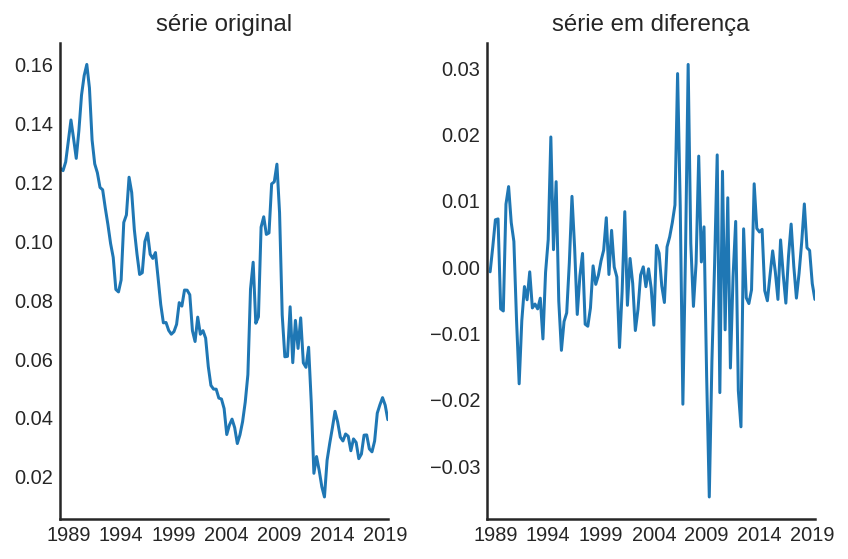

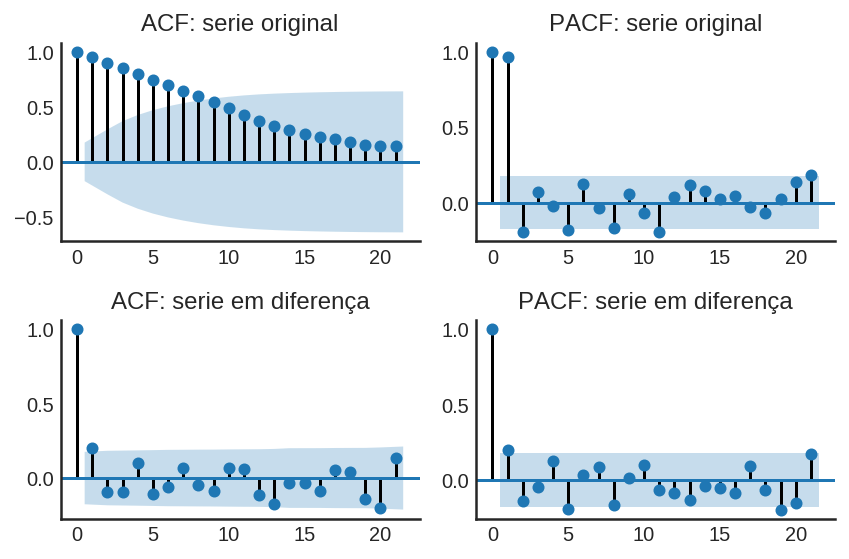


ZIVOT ANDREWS
        Zivot-Andrews Results        
Test Statistic                 -4.721
P-value                         0.067
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -6.296
P-value                         0.001
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF
   Augmented Dickey-Fuller Results   
Test Statistic                 -1.891
P-value                         0.336
Lags                                1
------

In [9]:
testes_raiz(df['Taxa Própria'])

**Conclusão:** Será tomada em primeira diferença.

## Inflação

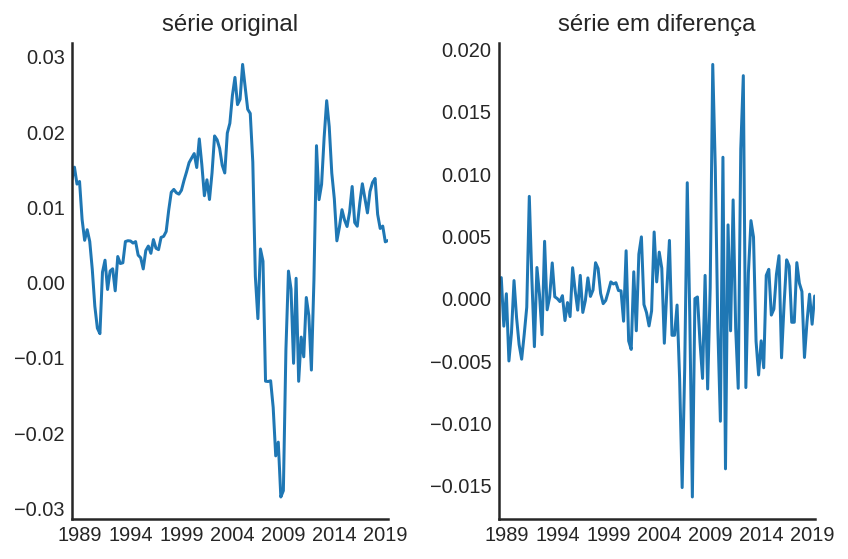

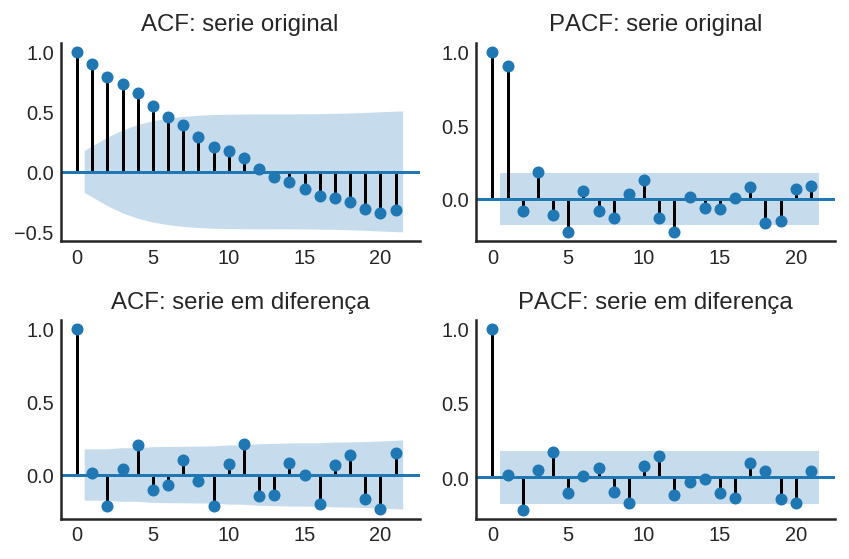


ZIVOT ANDREWS
        Zivot-Andrews Results        
Test Statistic                 -5.338
P-value                         0.008
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                -10.098
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.769
P-value                         0.063
Lags                                4
------

In [10]:
testes_raiz(df['Inflação'])

## Taxa de juros das hipotecas

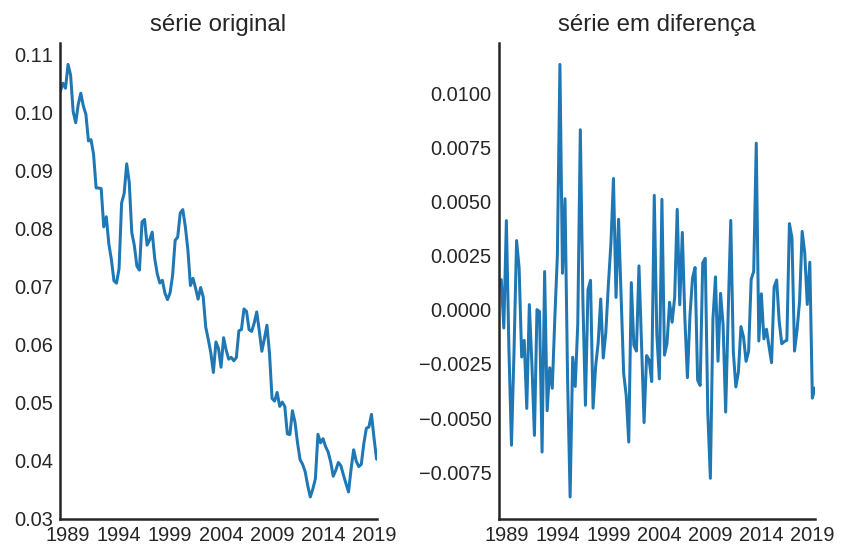

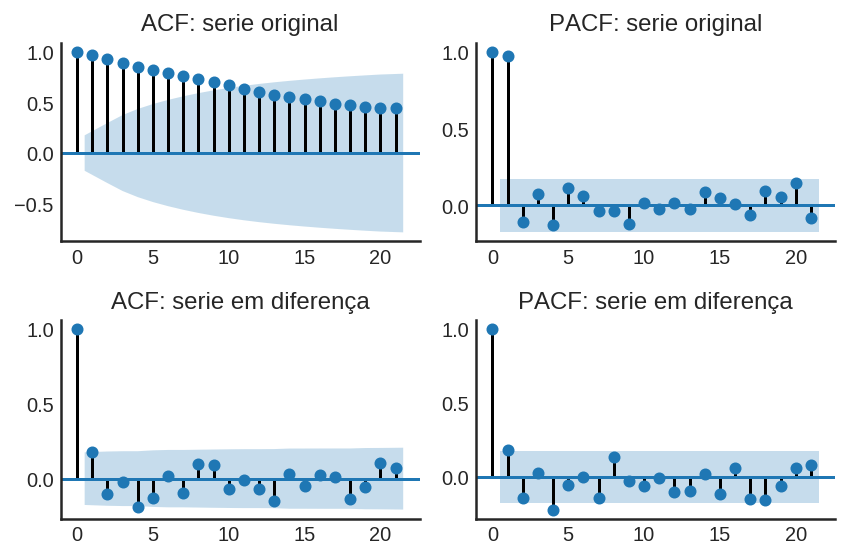


ZIVOT ANDREWS
        Zivot-Andrews Results        
Test Statistic                 -4.443
P-value                         0.239
Lags                                1
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -5.58 (1%), -5.07 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -7.121
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.641
P-value                         0.027
Lags                  

In [11]:
testes_raiz(df['Taxa de juros'], original_trend='ct')

## Investimento residencial  - Inflação de imóveis

Resta testar se existe alguma relação de longo prazo entre inflação de imóveis e investimento residencial.

Testando: 

$$
y = g_Z - \text{Infla} 
$$


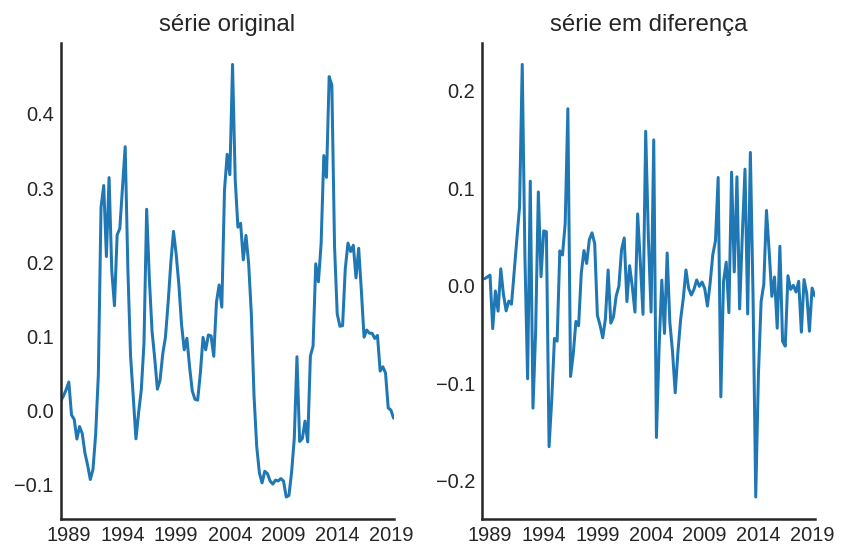

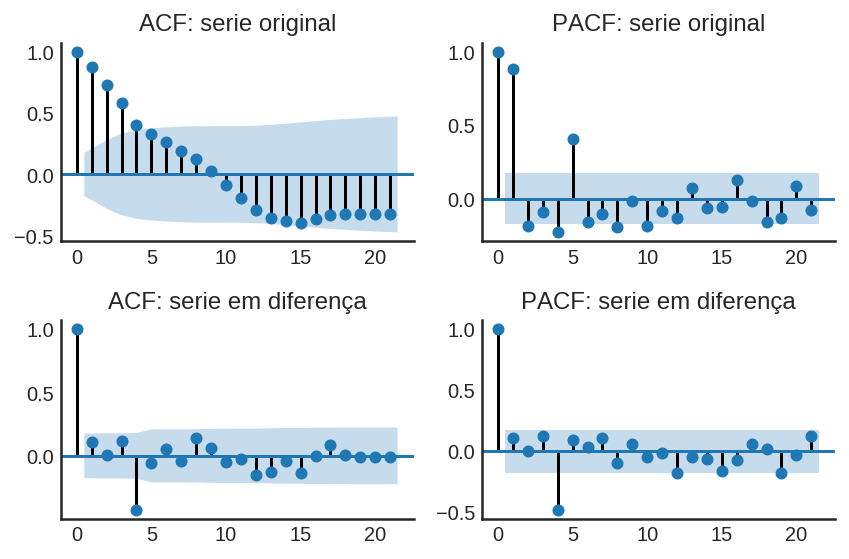


ZIVOT ANDREWS
        Zivot-Andrews Results        
Test Statistic                 -3.854
P-value                         0.444
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -8.066
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.334
P-value                         0.013
Lags                                7
------

In [12]:
testes_raiz(df=df["gZ"] - df["Inflação"])

# Teste de cointegração

In [13]:
%%R 
library(urca)
df <- read.csv("./Dados_yeojohnson.csv", encoding="UTF-8")
df <- df[,c(6,7)]
names(df) <- c("TaxaP", "gZ")
df <- na.omit(df[,c("TaxaP", "gZ")])
df <- ts(data = df, start = c(1987,01), frequency = 4)
PO <- ca.po(df, demean = "trend", lag = "long", type="Pu")
summary(PO)


######################################## 
# Phillips and Ouliaris Unit Root Test # 
######################################## 

Test of type Pu 
detrending of series with constant and linear trend 


Call:
lm(formula = z[, 1] ~ z[, -1] + trd)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.028912 -0.010291 -0.001370  0.007718  0.039962 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.358e-01  2.657e-03   51.12   <2e-16 ***
z[, -1]     -1.198e-01  8.971e-03  -13.35   <2e-16 ***
trd         -7.658e-04  3.472e-05  -22.06   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01414 on 123 degrees of freedom
Multiple R-squared:  0.8521,	Adjusted R-squared:  0.8497 
F-statistic: 354.2 on 2 and 123 DF,  p-value: < 2.2e-16


Value of test-statistic is: 52.2146 

Critical values of Pu are:
                  10pct    5pct    1pct
critical values 41.2488 48.8439 65.1714



In [14]:
%%R 
library(urca)
df <- read.csv("./Dados_yeojohnson.csv", encoding="UTF-8")
df <- df[,c(6,7)]
names(df) <- c("TaxaP", "gZ")
df <- na.omit(df[,c("TaxaP", "gZ")])
df <- ts(data = df, start = c(1987,01), frequency = 4)
jotest=ca.jo(df[,c('gZ', 'TaxaP')], type="trace", K=5, ecdet="trend", spec="longrun") 
summary(jotest)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend in cointegration 

Eigenvalues (lambda):
[1] 9.932337e-02 8.251738e-02 2.775558e-17

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 | 10.42 10.49 12.25 16.26
r = 0  | 23.08 22.76 25.32 30.45

Eigenvectors, normalised to first column:
(These are the cointegration relations)

               gZ.l5      TaxaP.l5    trend.l5
gZ.l5    1.000000000  1.000000e+00  1.00000000
TaxaP.l5 6.825290606 -3.237900e-01 -7.74201595
trend.l5 0.005177442 -4.222196e-05 -0.05260399

Weights W:
(This is the loading matrix)

              gZ.l5    TaxaP.l5     trend.l5
gZ.d    -0.11295243 -0.10795190 3.023995e-18
TaxaP.d -0.03151788  0.01382608 1.018348e-18



In [15]:
print('\nTestando para lag = 0')
results = select_coint_rank(endog=df[['gZ', 'Taxa Própria']], det_order=1, k_ar_diff=0)
print(results.summary())
print(f'rank = {results.rank}\n')

print('\nTestando para lag = 4')
results = select_coint_rank(endog=df[['gZ', 'Taxa Própria']], det_order=1, k_ar_diff=4)
print(results.summary())
print(f'rank = {results.rank}\n')

print('\nTestando para lag = 5')
results = select_coint_rank(endog=df[['gZ', 'Taxa Própria']], det_order=1, k_ar_diff=5)
print(results.summary())
print(f'rank = {results.rank}\n')

print(f'rank = {results.rank}\n')

print('\nTestando para lag = 1')
cointegracao(ts0=df[['gZ']],ts1=df[['Taxa Própria']],signif=0.05, lag=1)

print('\nTestando para lag = 4')
cointegracao(ts0=df[['gZ']],ts1=df[['Taxa Própria']],signif=0.05, lag=4)

print('\nTestando para lag = 5')
cointegracao(ts0=df[['gZ']],ts1=df[['Taxa Própria']],signif=0.05, lag=5)


Testando para lag = 0
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          34.42          18.40
  1   2          5.221          3.841
-------------------------------------
rank = 2


Testando para lag = 4
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          22.87          18.40
  1   2          10.40          3.841
-------------------------------------
rank = 2


Testando para lag = 5
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          19.53          18.40
  1   2          6.980          3.841
-------------------------------------
rank = 2

rank = 2


Testando para lag = 1

ENGEL-GRANGER TEST

Testing trend = nc

Null Hypoth

In [16]:
results = select_coint_rank(endog=df[['gZ', 'Inflação', 'Taxa de juros']], det_order=1, k_ar_diff=5)
print(results.summary())
print(f'rank = {results.rank}')


print('\nTestando para lag = 1')
cointegracao(ts0=df[['gZ']],ts1=df[['Inflação', 'Taxa de juros']],signif=0.05, lag=1)

print('\nTestando para lag = 5')
cointegracao(ts0=df[['gZ']],ts1=df[['Inflação', 'Taxa de juros']],signif=0.05, lag=5)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          34.33          35.01
-------------------------------------
rank = 0

Testando para lag = 1

ENGEL-GRANGER TEST

Testing trend = nc

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.350218
p-value: 0.001884
CONCLUSION: REJECT null Hypothesis: there IS cointegration

Testing trend = c

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.399154
p-value: 0.007080
CONCLUSION: REJECT null Hypothesis: there IS cointegration

Testing trend = ct

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -6.164727
p-value: 0.000019
CONCLUSION: REJECT null Hypothesis: there IS cointegration

Testing trend = ctt

Null Hypothesis: there is NO cointegration
Alternative Hypot

In [17]:
results = select_coint_rank(endog=df[['gZ', 'Inflação']], det_order=1, k_ar_diff=5)
print(results.summary())
print(f'rank = {results.rank}')

print('\nTestando para lag = 1')
cointegracao(ts0=df[['gZ']],ts1=df[['Inflação']],signif=0.05, lag=1)

print('\nTestando para lag = 5')
cointegracao(ts0=df[['gZ']],ts1=df[['Inflação']],signif=0.05, lag=5)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          18.27          18.40
-------------------------------------
rank = 0

Testando para lag = 1

ENGEL-GRANGER TEST

Testing trend = nc

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.230641
p-value: 0.000454
CONCLUSION: REJECT null Hypothesis: there IS cointegration

Testing trend = c

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.406013
p-value: 0.001740
CONCLUSION: REJECT null Hypothesis: there IS cointegration

Testing trend = ct

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.374117
p-value: 0.008598
CONCLUSION: REJECT null Hypothesis: there IS cointegration

Testing trend = ctt

Null Hypothesis: there is NO cointegration
Alternative Hypot

# VECM

In [18]:
from statsmodels.tsa.vector_ar.vecm import select_order

det = 'coli'
lag_select = select_order(df[['Taxa Própria', "gZ"]],
                          maxlags=15,
                          deterministic=det)

with open('./tabs/VECM_lag_order.tex', 'w') as fh:
    fh.write(
        lag_select.summary().as_latex_tabular(tile="Selação ordem do VECM"))

lag_select.summary()

,AIC,BIC,FPE,HQIC
0,-14.91,-14.66*,3.352e-07,-14.81
1,-14.94,-14.59,3.263e-07,-14.80
2,-14.91,-14.46,3.363e-07,-14.73
3,-14.99,-14.45,3.086e-07,-14.77
4,-15.14,-14.50,2.672e-07,-14.88*
5,-15.15*,-14.41,2.637e-07*,-14.85
6,-15.13,-14.29,2.700e-07,-14.79
7,-15.13,-14.19,2.707e-07,-14.75
8,-15.11,-14.08,2.753e-07,-14.69
9,-15.06,-13.92,2.928e-07,-14.60


In [19]:
model = VECM(
    endog = df[['Taxa Própria', "gZ"]],
    #exog=df[['Taxa de juros']],
    k_ar_diff=5,
    deterministic=det
)
results = model.fit()

with open('./tabs/VECM_ajuste.tex','w') as fh:
    fh.write(results.summary().as_latex())

print(results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Taxa Própria
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0071      0.004     -1.733      0.083      -0.015       0.001
L1.Taxa Própria     0.1848      0.095      1.945      0.052      -0.001       0.371
L1.gZ              -0.0231      0.016     -1.412      0.158      -0.055       0.009
L2.Taxa Própria    -0.1673      0.094     -1.788      0.074      -0.351       0.016
L2.gZ              -0.0152      0.014     -1.113      0.266      -0.042       0.012
L3.Taxa Própria    -0.1530      0.099     -1.543      0.123      -0.347       0.041
L3.gZ              -0.0040      0.013     -0.297      0.767      -0.030       0.022
L4.Taxa Própria     0.1315      0.097      1.356      0.175      -0.059       0.322
L4.gZ              -0.0165      0.013     -1.257      0.209      -0.

## Pós Estimação

### Resíduos

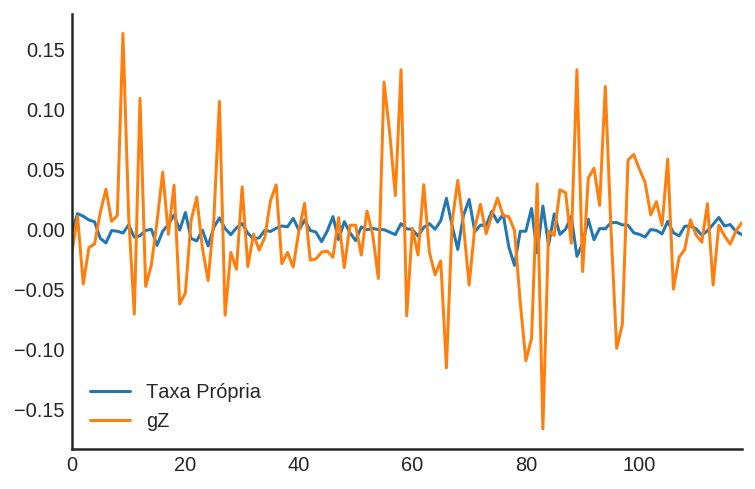

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         45.24          53.38   0.195 38
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         49.35          53.38   0.103 38
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  TAXA PRÓPRIA . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3 ?

In [20]:
residuals = analise_residuos(results=results)

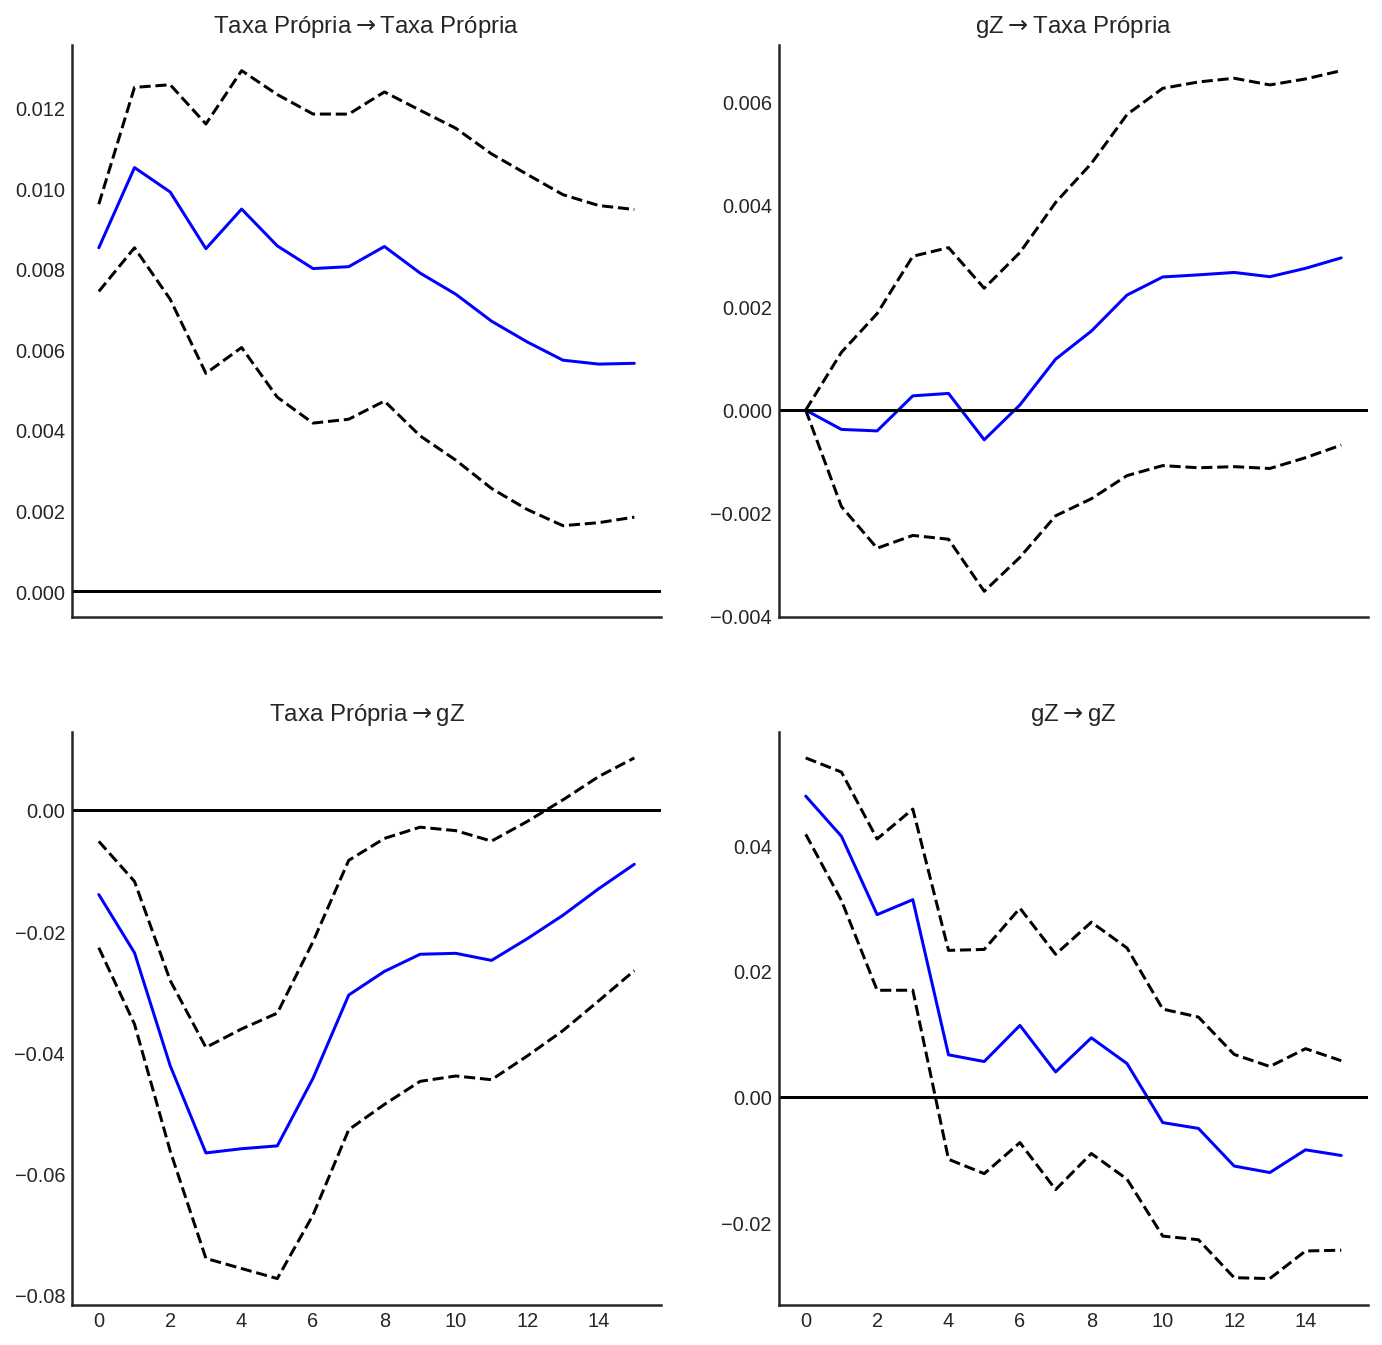

In [21]:
p = results.irf(15).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECMOrth.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

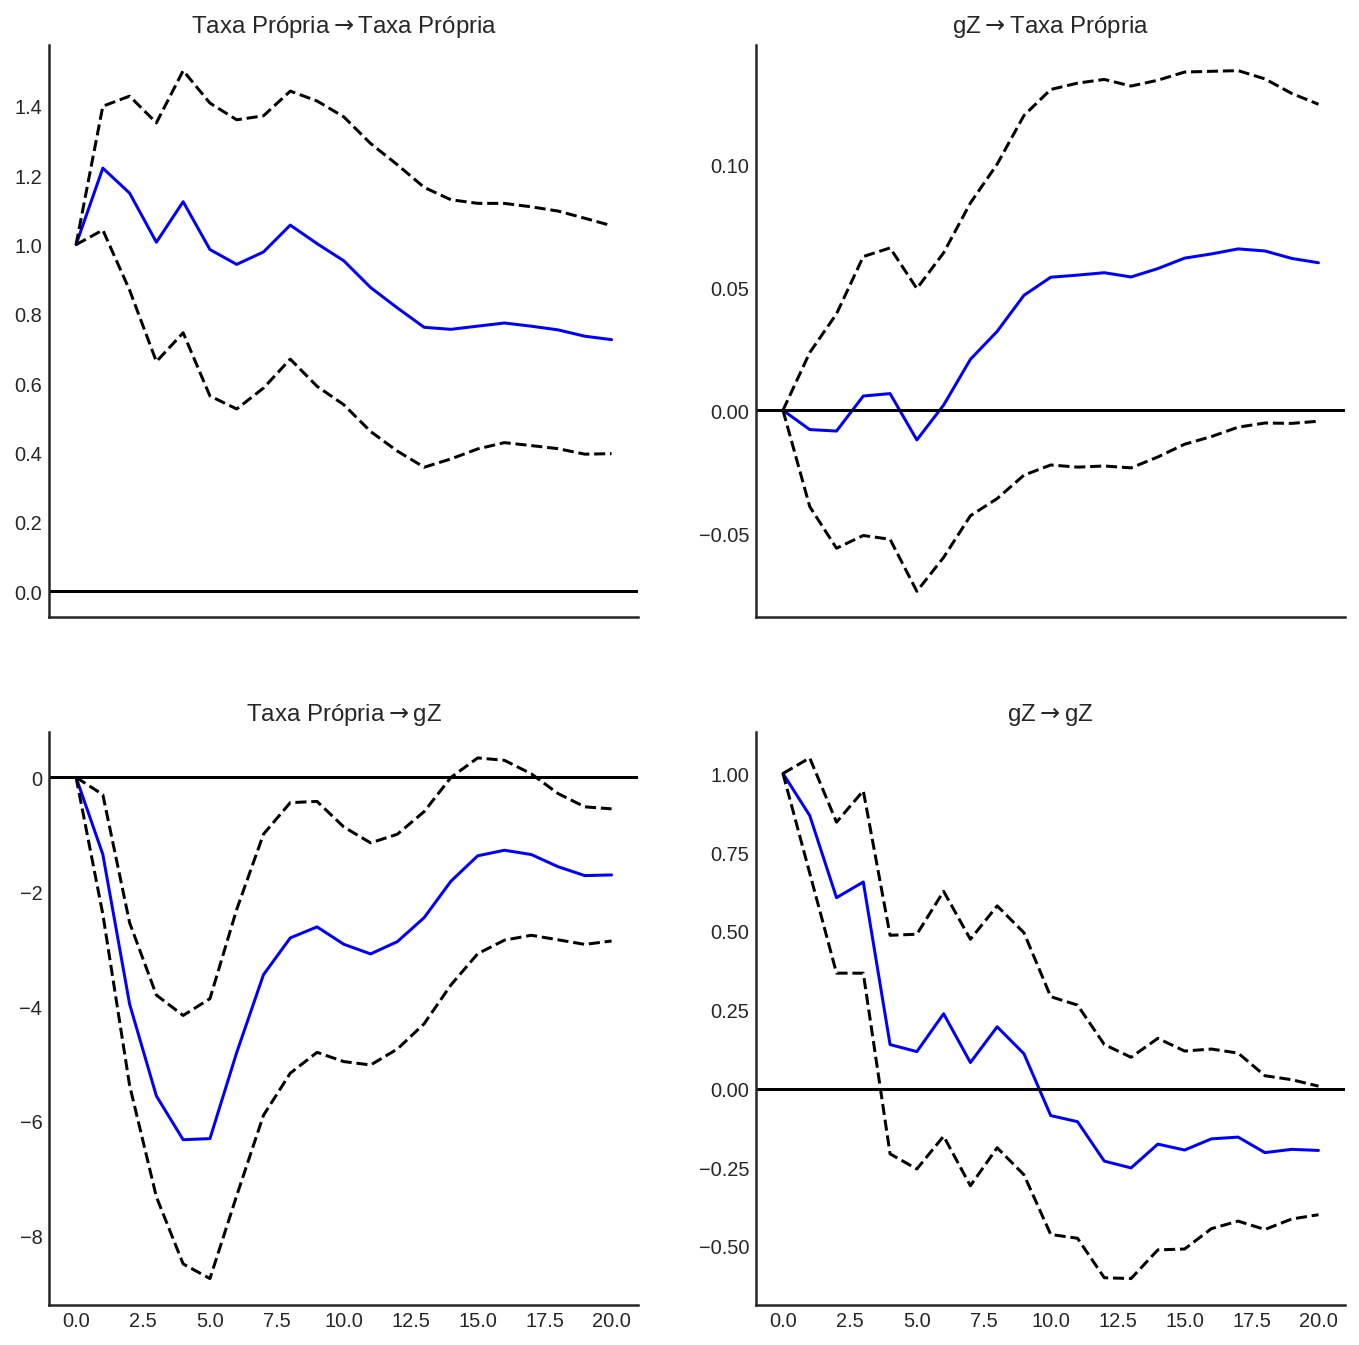

In [22]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

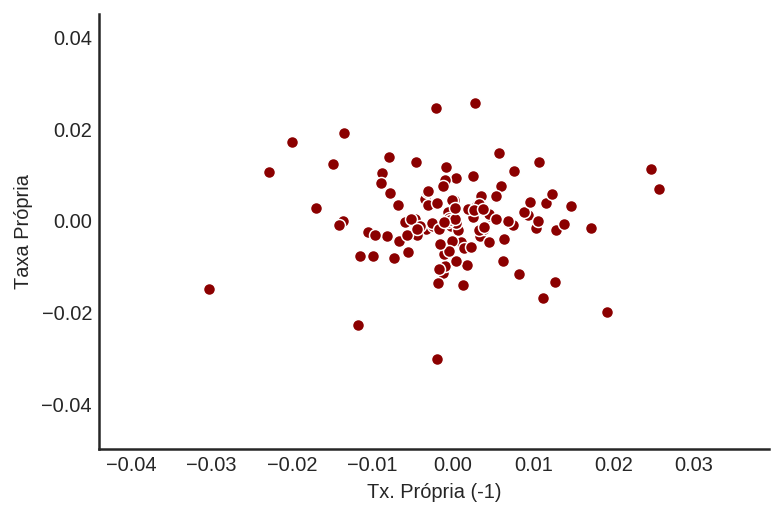

In [23]:
sns.scatterplot(y = residuals['Taxa Própria'], x = residuals['Taxa Própria'].shift(-1), color = 'darkred')
sns.despine()
plt.xlabel("Tx. Própria (-1)")
plt.show()

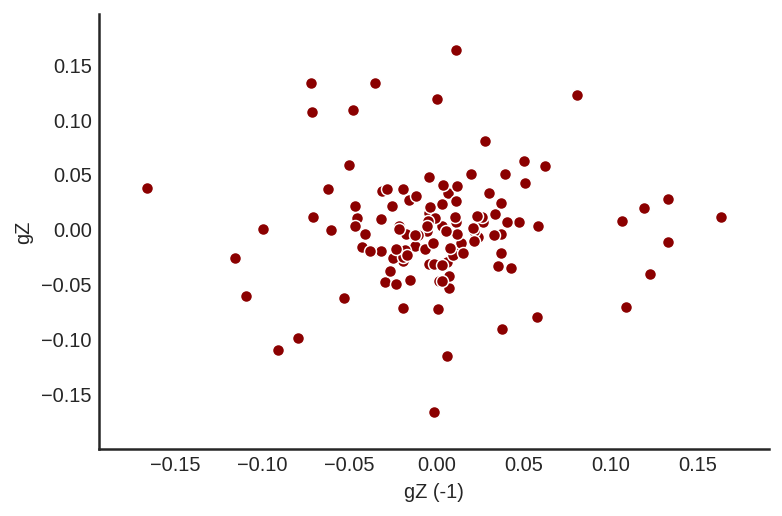

In [24]:
sns.scatterplot(y = residuals['gZ'], x = residuals['gZ'].shift(-1), color = 'darkred')
sns.despine()
plt.xlabel("gZ (-1)")
plt.show()

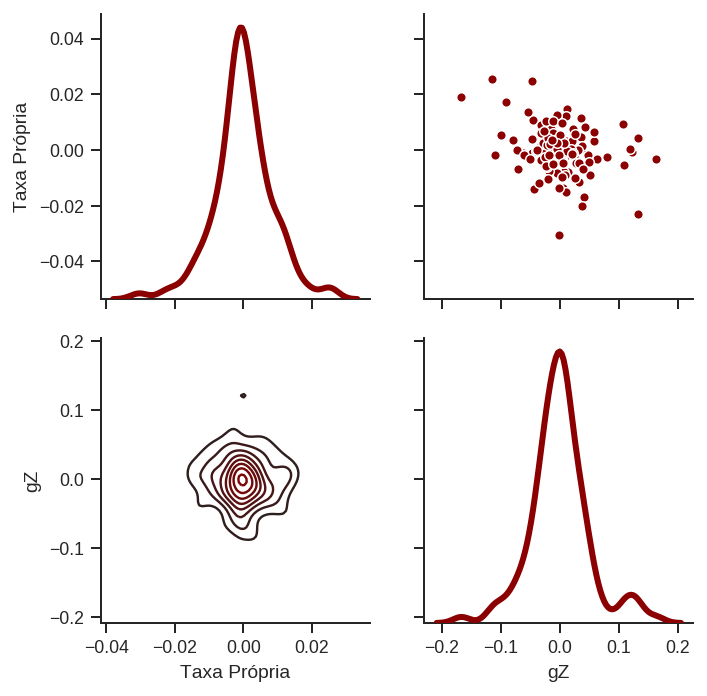

In [25]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## FEVD

corrigir!!

In [26]:
%%R -o fevd_gz
library(tsDyn)
library(readr)
df <- read.csv("./Dados_yeojohnson.csv", encoding="UTF-8")
df <- df[,c(6,7)]
names(df) <- c("TaxaP", "gZ")
df <- na.omit(df[,c("TaxaP", "gZ")])
df <- ts(data = df, start = c(1987,01), frequency = 4)
model <- tsDyn::VECM(data = df, lag = 5, r = 1, estim = "ML")
fevd_gz = data.frame(tsDyn::fevd(model, 20)$gZ)

R[write to console]: Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff



In [27]:
%%R -o fevd_tx
fevd_tx = data.frame(tsDyn::fevd(model, 20)$TaxaP)

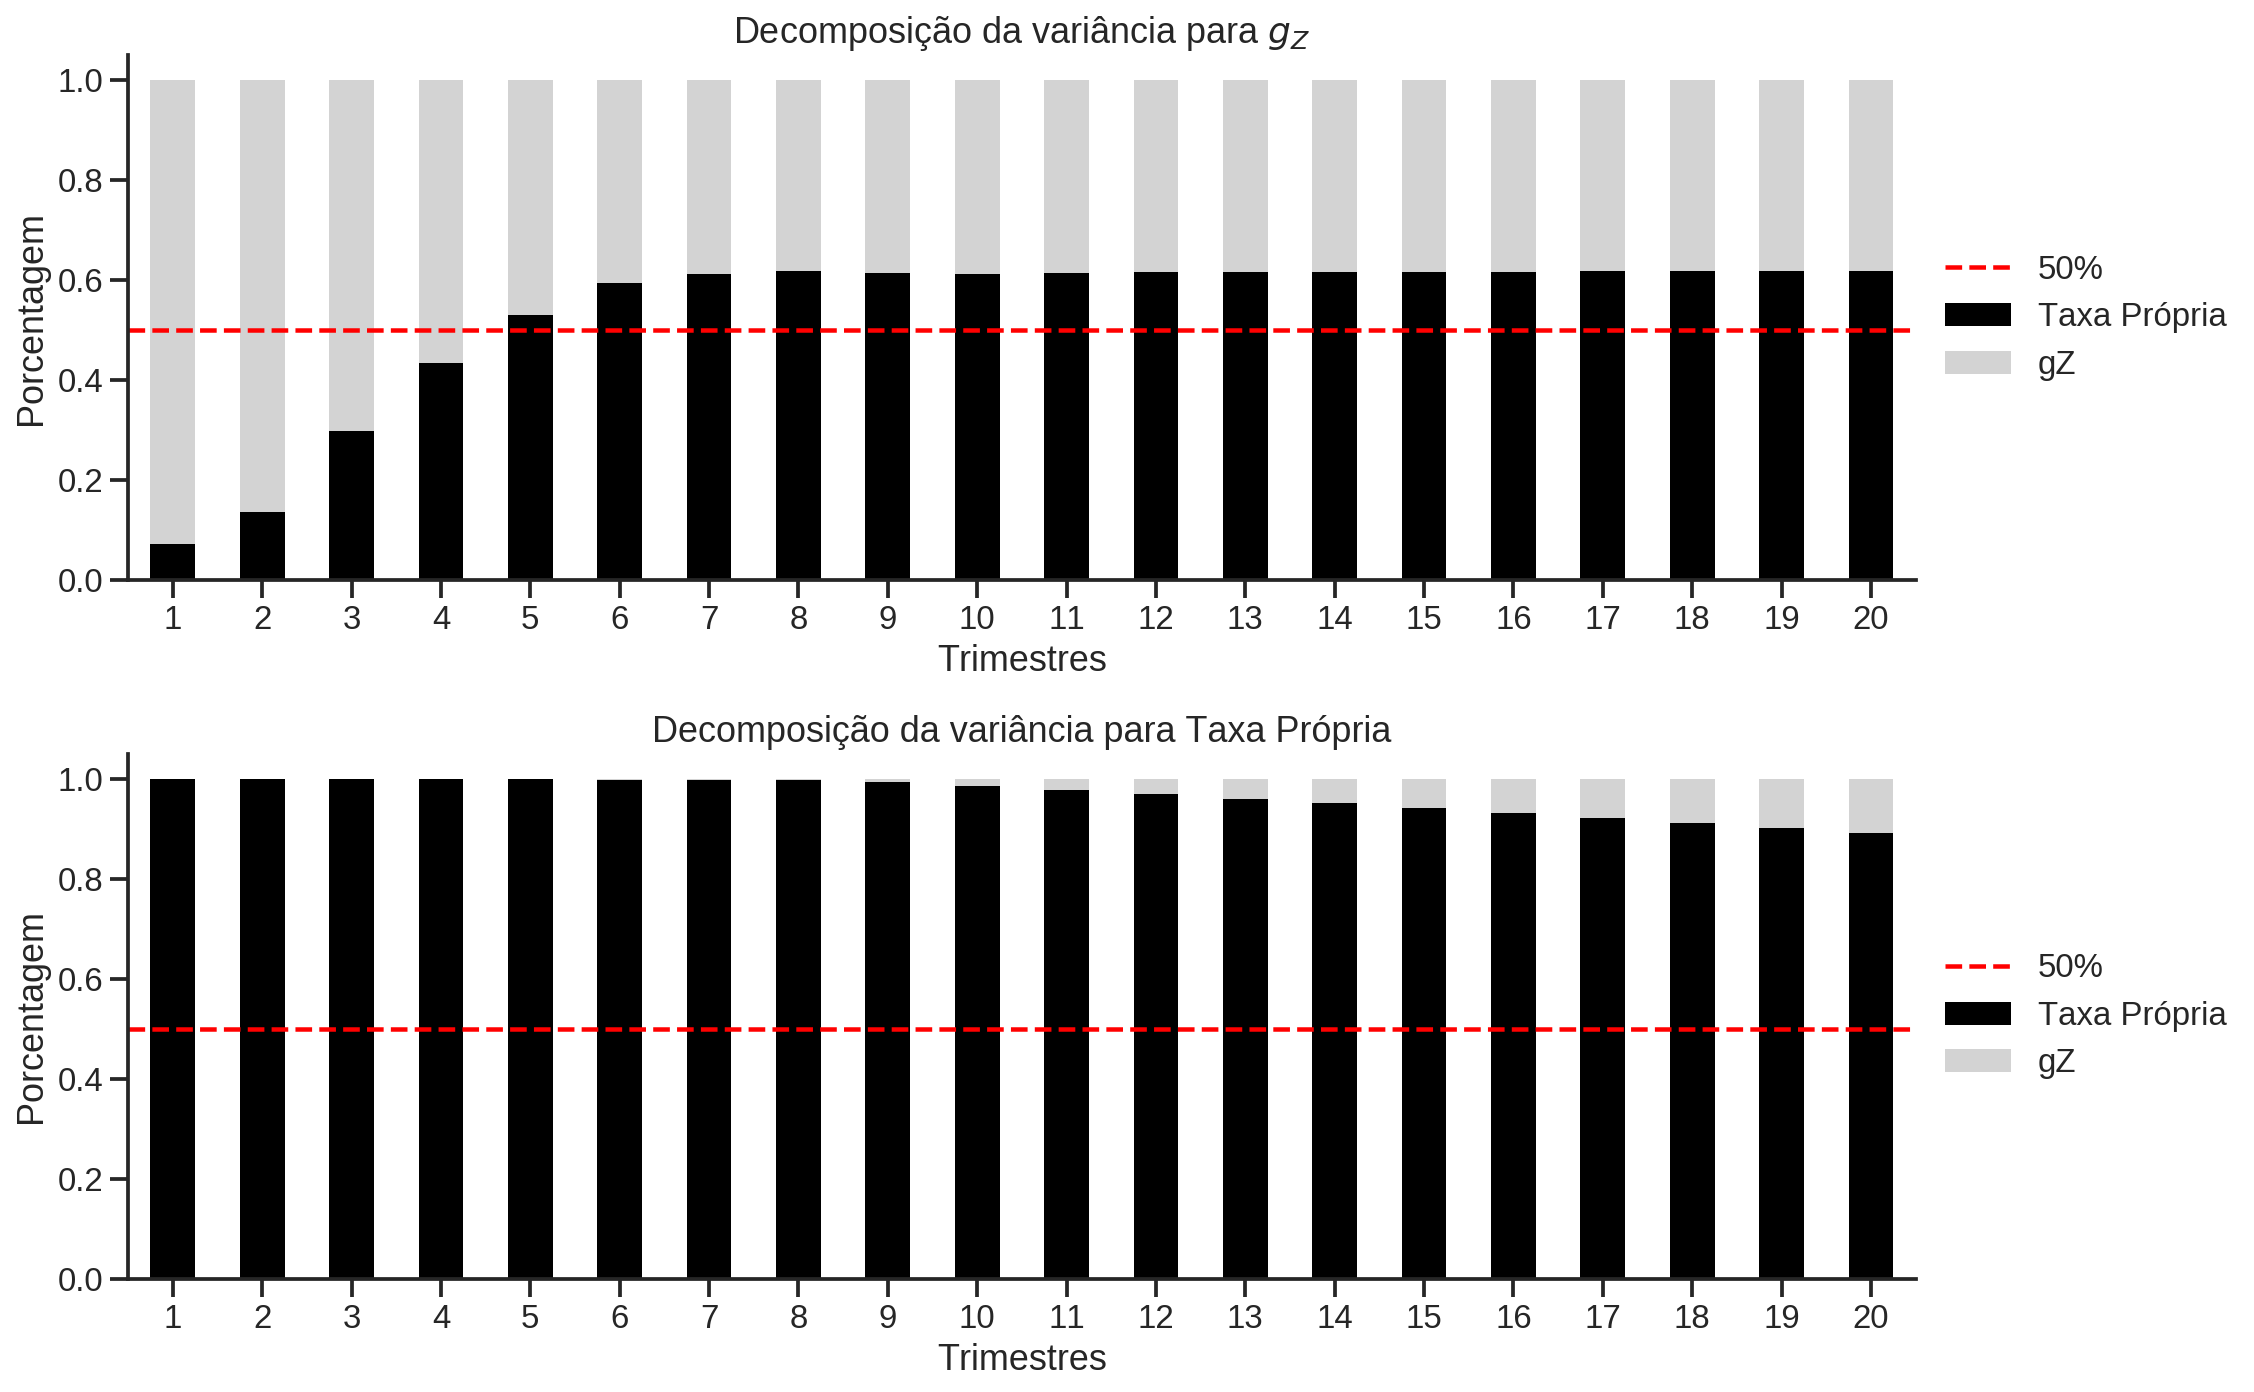

In [28]:
sns.set_context('talk')
fig, ax = plt.subplots(2,1, figsize = (16,10))

fevd_gz.plot(
    ax=ax[0], 
    title = "Decomposição da variância para $g_Z$", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True
)
ax[0].set_xlabel('Trimestres')
ax[0].set_ylabel('Porcentagem')
ax[0].axhline(y=0.5, color = 'red', ls = '--')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Taxa Própria", "gZ"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)


fevd_tx.plot(
    ax=ax[1], 
    title = "Decomposição da variância para Taxa Própria", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True,
)
ax[1].axhline(y=0.5, color = 'red', ls = '--')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Taxa Própria", "gZ"))
ax[1].set_xlabel('Trimestres')
ax[1].set_ylabel('Porcentagem')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

sns.despine()
plt.tight_layout()
plt.show()
fig.savefig("./figs/FEVD_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

# VAR

**Dúvida:** Variável exógena do VAR deve ser estacionária também?

In [29]:
model = VAR(
    df[["d_Inflação", 'gZ']],
    exog=df[['Taxa de juros']]
)
print(model.select_order(maxlags=15).summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -14.41      -14.32   5.498e-07      -14.37
1       -15.91     -15.71*   1.237e-07      -15.83
2       -15.98      -15.68   1.151e-07      -15.86
3       -15.99      -15.59   1.142e-07      -15.83
4       -16.00      -15.51   1.128e-07      -15.80
5      -16.19*      -15.60  9.348e-08*     -15.95*
6       -16.19      -15.50   9.372e-08      -15.91
7       -16.13      -15.35   9.875e-08      -15.82
8       -16.10      -15.22   1.023e-07      -15.74
9       -16.09      -15.11   1.032e-07      -15.70
10      -16.05      -14.97   1.080e-07      -15.61
11      -16.03      -14.85   1.113e-07      -15.55
12      -15.98      -14.70   1.172e-07      -15.46
13      -15.93      -14.55   1.235e-07      -15.37
14      -15.89      -14.42   1.293e-07      -15.29
15      -15.84      -14.27   1.366e-07      -15.20
-------------------------------

Adotando o BIC como critério de seleção dada a parciomônia, estima-se uma VAR de ordem 5.

## Estimação

In [30]:
results = model.fit(ic='aic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           ter, 26, nov, 2019
Time:                     17:10:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -15.6548
Nobs:                     119.000    HQIC:                  -16.0431
Log likelihood:           660.659    FPE:                8.28288e-08
AIC:                     -16.3087    Det(Omega_mle):     6.63089e-08
--------------------------------------------------------------------
Results for equation d_Inflação
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.002166         0.001742            1.243           0.214
exog0                -0.026499         0.025308           -1.047           0.295
L1.d_Inflação         0.011876         0.104692        

## Inspeção

### Autocorrelação dos resíduos 

**OBS:** série consigo mesma na diagonal principal.

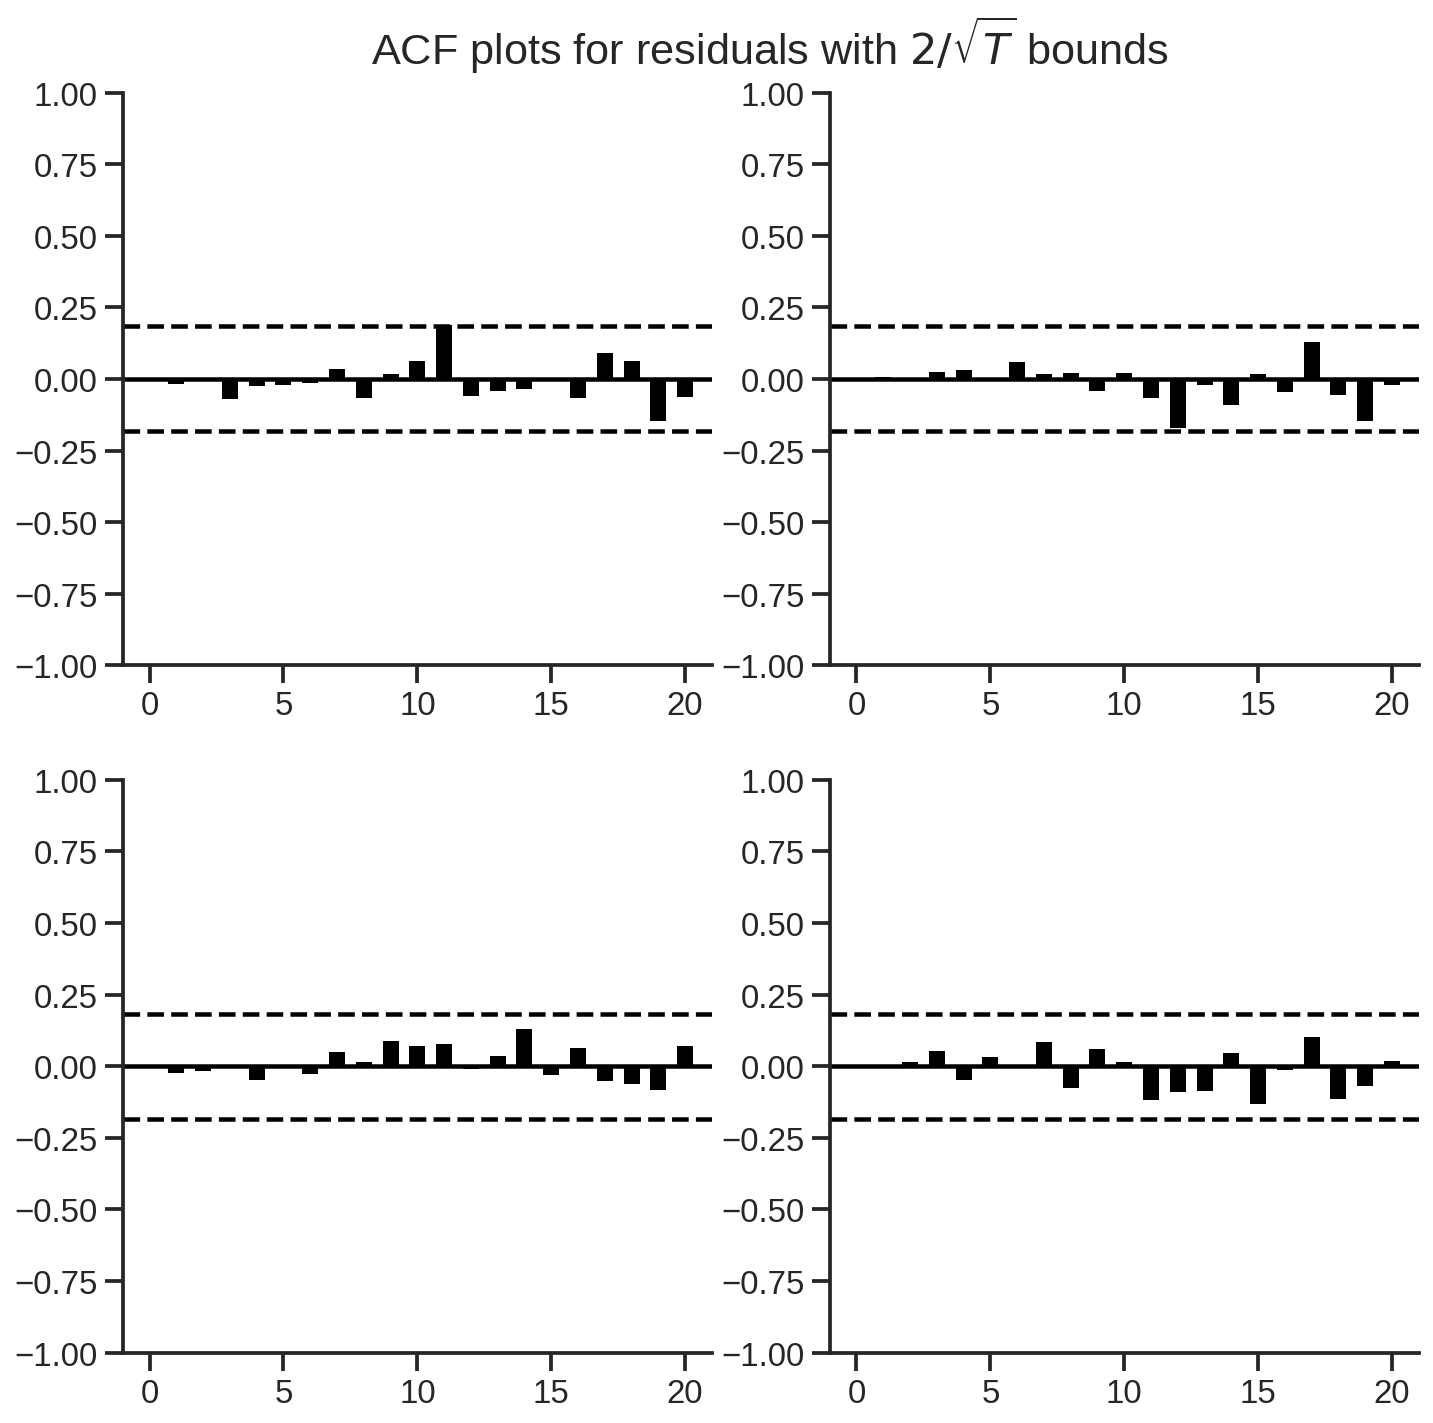

In [31]:
results.plot_acorr(nlags = 20)
sns.despine()
plt.show()

**Conclusão:** Pela inspeção gráfica, o modelo não apresenta autocorrelação seria dos resíduos.

### Estabilidade

In [32]:
print("Estável:", results.is_stable(verbose=True))

Eigenvalues of VAR(1) rep
0.8172342178119125
0.8598030446623606
0.8598030446623606
0.8089951893244565
0.8089951893244565
0.5524443878764412
0.5524443878764412
0.8279344399664852
0.8279344399664852
0.7670114942259257
0.7670114942259257
0.6510459947813003
Estável: True


**OBS:** Apesar de estar escrito VAR(1), os resultados acima correspondem ao VAR(p)

## Inspeção dos resíduos

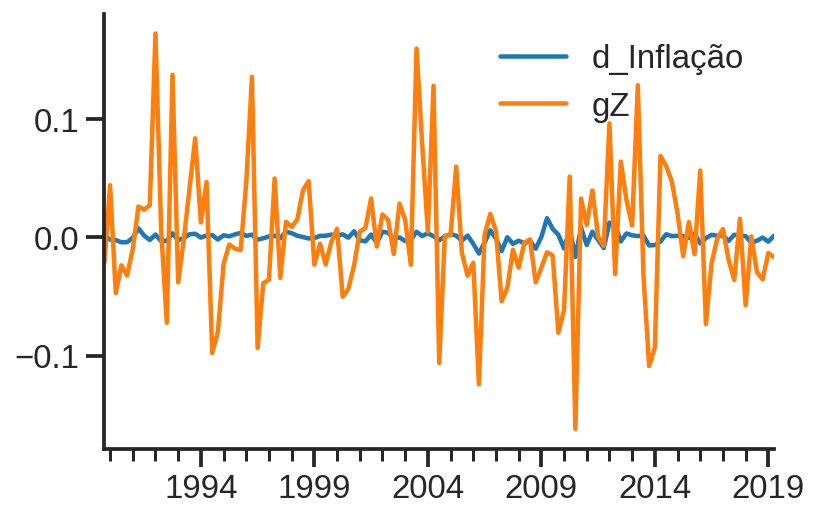

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         31.64          51.00   0.676 36
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         34.81          51.00   0.525 36
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  D_INFLAÇÃO . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3 ?  

In [33]:
residuals = analise_residuos(results=results)

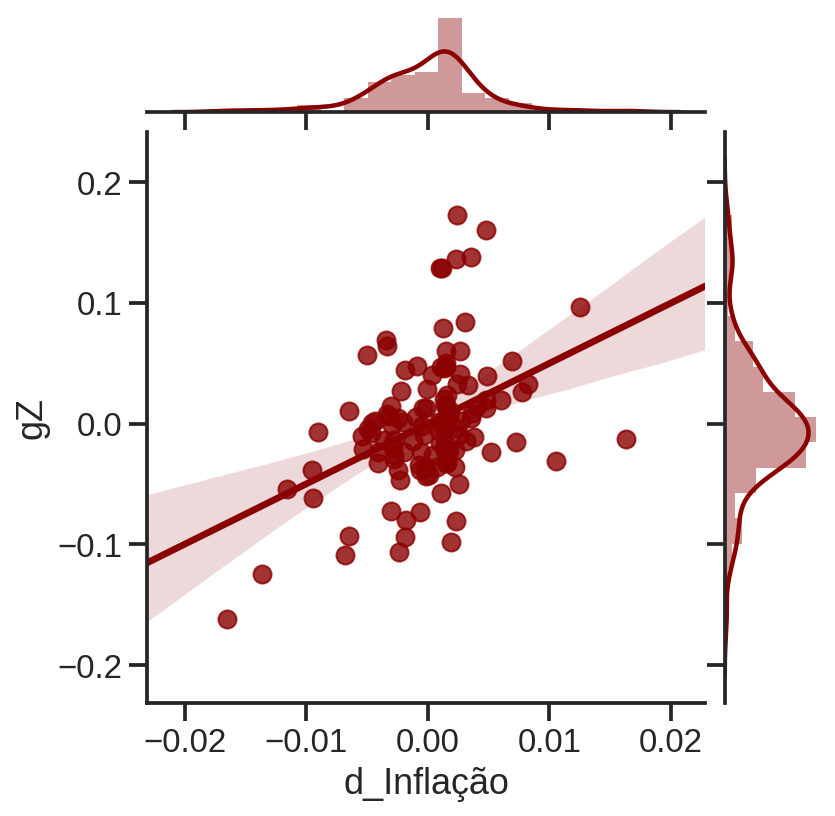

In [34]:
sns.set_context('talk')
ax = sns.jointplot(
    x = 'd_Inflação', 
    y = 'gZ', 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

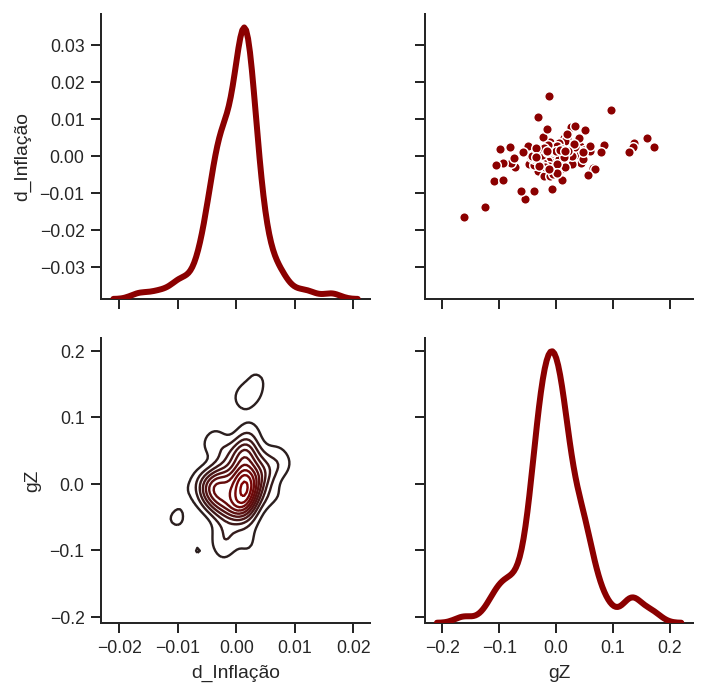

In [35]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4.png", dpi=300)

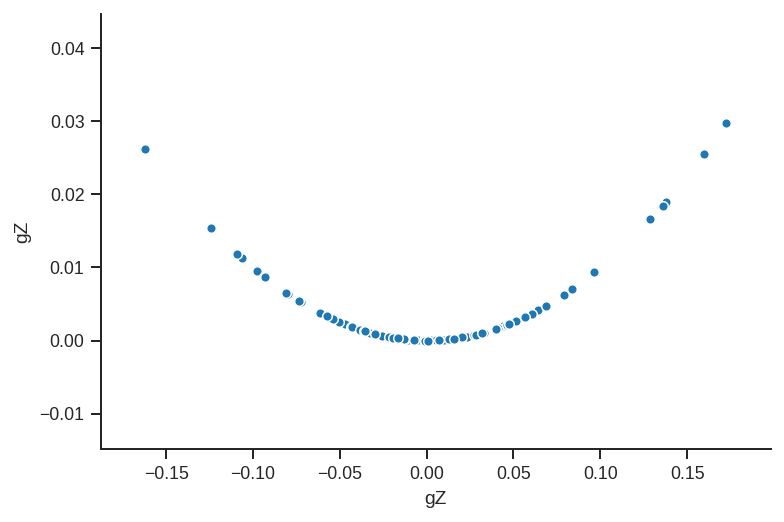

In [36]:
sns.scatterplot(x = residuals['gZ'], y = residuals['gZ']**2)
sns.despine()
plt.show()

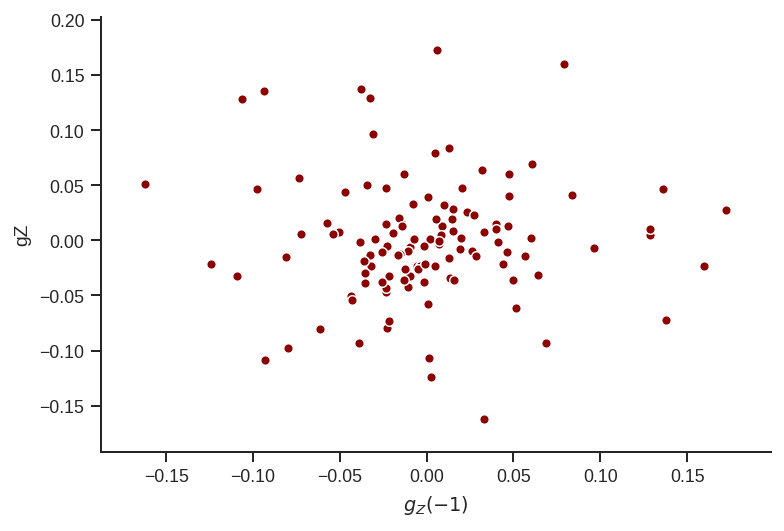

In [37]:
sns.scatterplot(
    y = residuals['gZ'], 
    x = residuals['gZ'].shift(-1), 
    color = 'darkred' 
)
sns.despine()
plt.xlabel("$g_Z(-1)$")
plt.show()

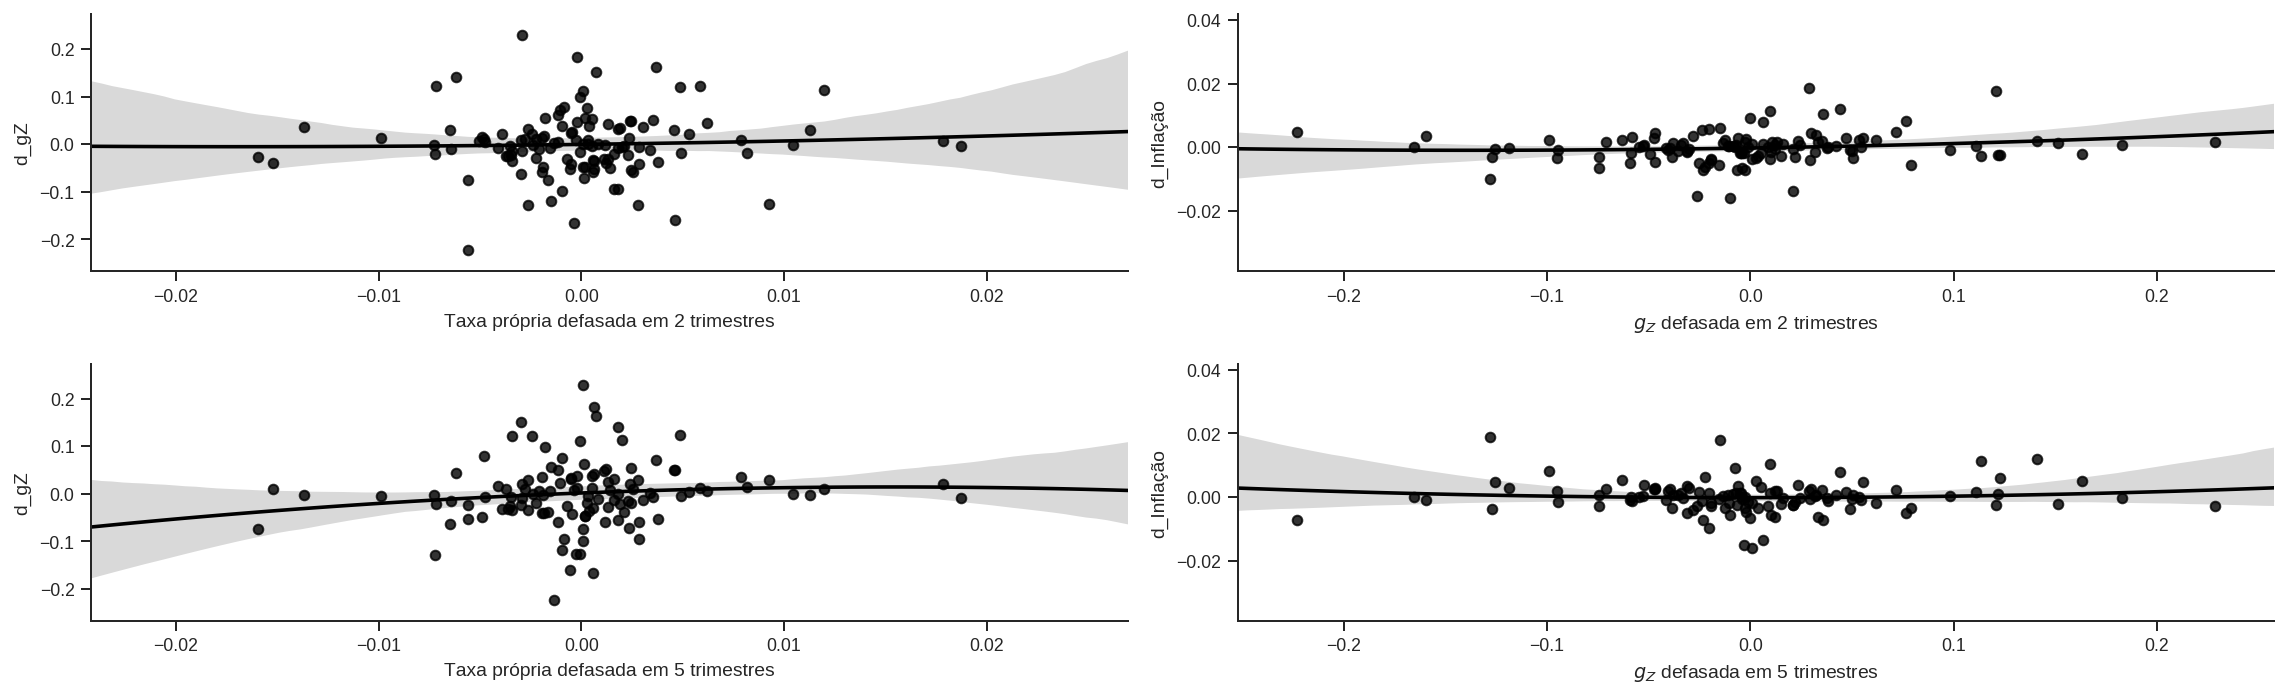

In [38]:
fig, ax = plt.subplots(2,2, figsize = (16,5))

trimestres = 2

sns.regplot(y = df["d_gZ"], x = df["d_Inflação"].shift(-trimestres), color = 'black', ax = ax[0,0], order = 2)
ax[0,0].set_xlabel('Taxa própria defasada em {} trimestres'.format(trimestres))

sns.regplot(x = df["d_gZ"].shift(-trimestres), y = df["d_Inflação"], color = 'black', ax = ax[0,1], order = 2)
ax[0,1].set_xlabel('$g_Z$ defasada em {} trimestres'.format(trimestres))


trimestres = 5

sns.regplot(y = df["d_gZ"], x = df["d_Inflação"].shift(-trimestres), color = 'black', ax = ax[1,0], order = 2)
ax[1,0].set_xlabel('Taxa própria defasada em {} trimestres'.format(trimestres))

sns.regplot(x = df["d_gZ"].shift(-trimestres), y = df["d_Inflação"], color = 'black', ax = ax[1,1], order = 2)
ax[1,1].set_xlabel('$g_Z$ defasada em {} trimestres'.format(trimestres))

sns.despine()
fig.tight_layout()
plt.show()
fig.savefig("./figs/Scatter_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Função resposta ao impulso

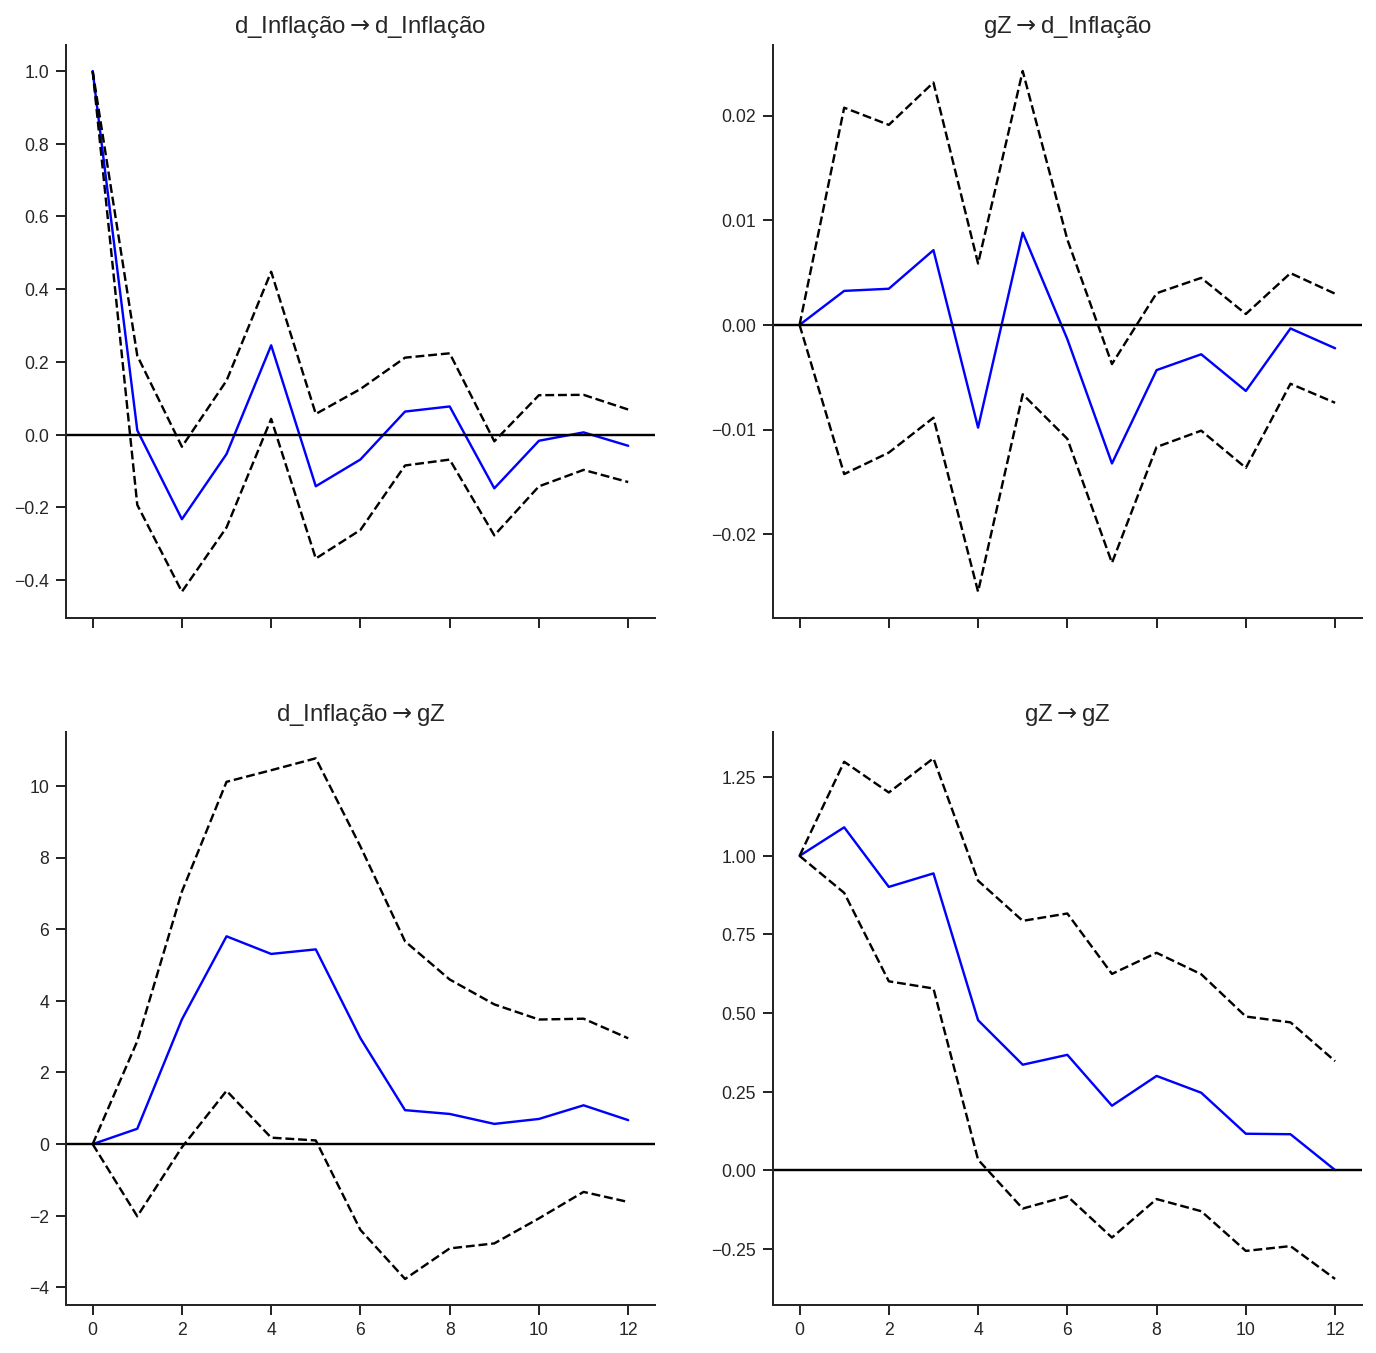

In [39]:
p = results.irf(12).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso.png", dpi = 300)

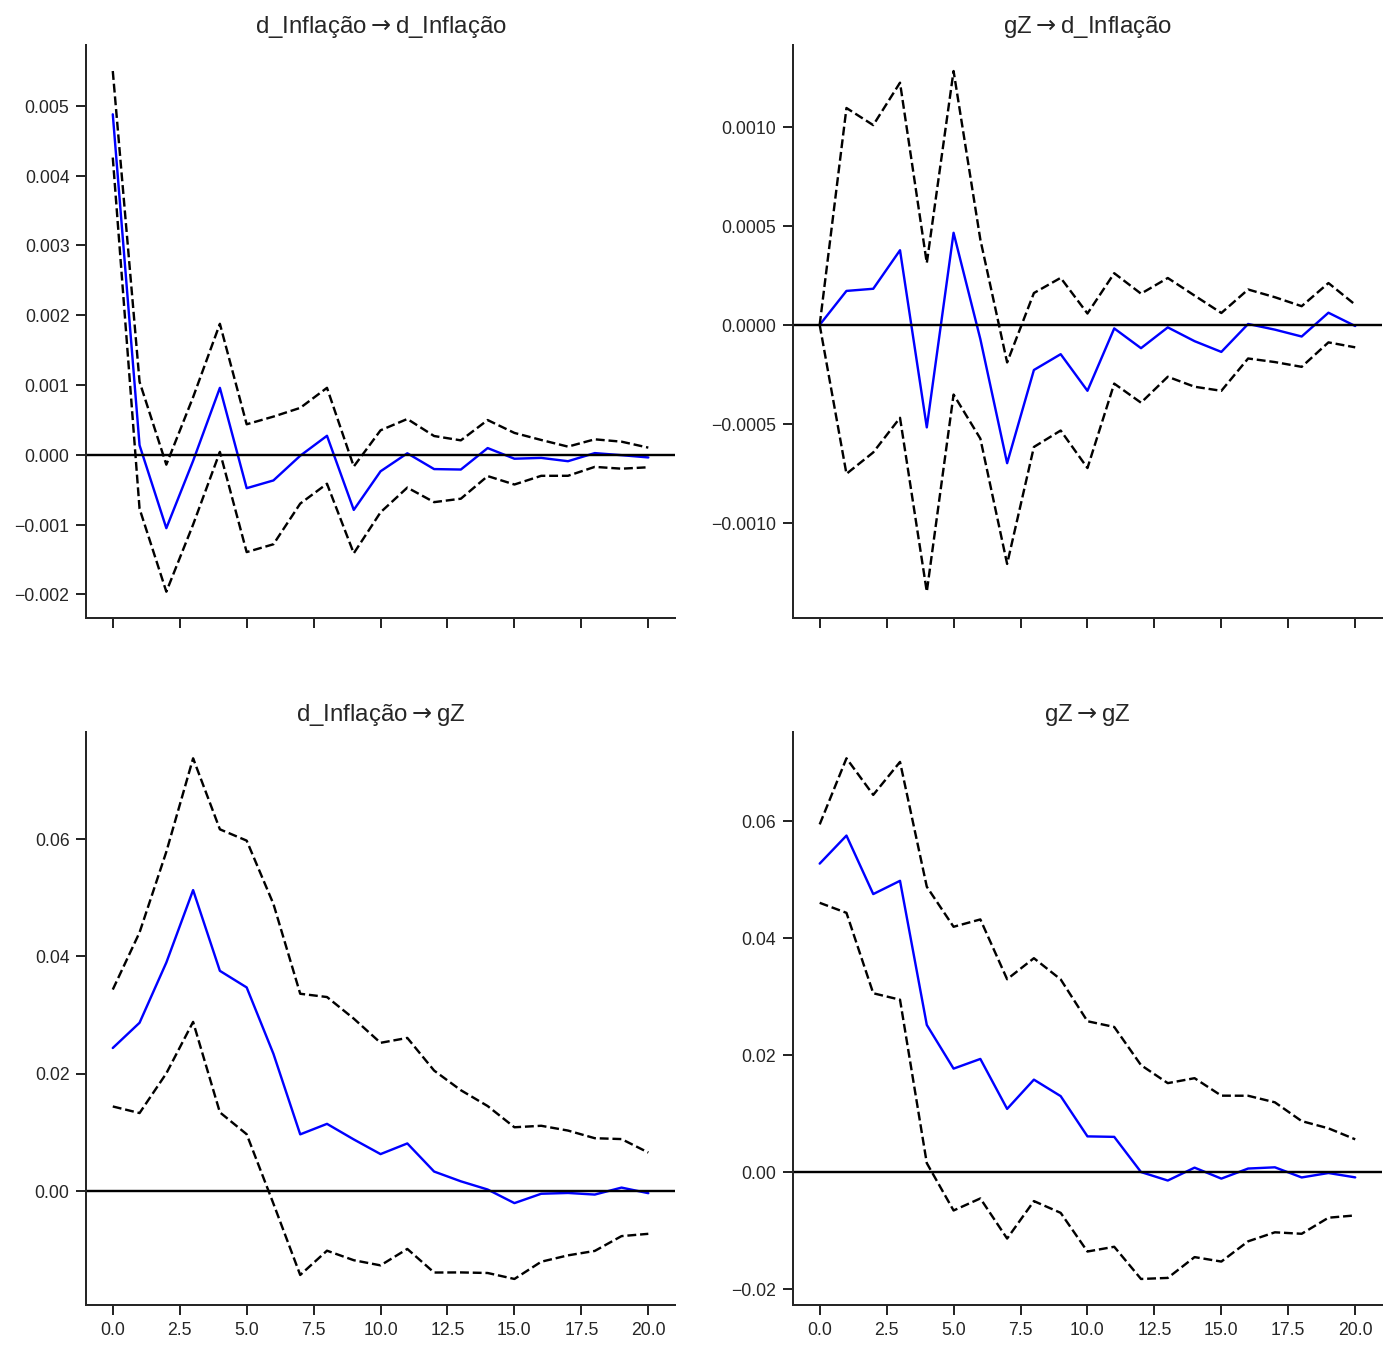

In [40]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Orth.png", dpi = 300)

## Efeito cumulativo

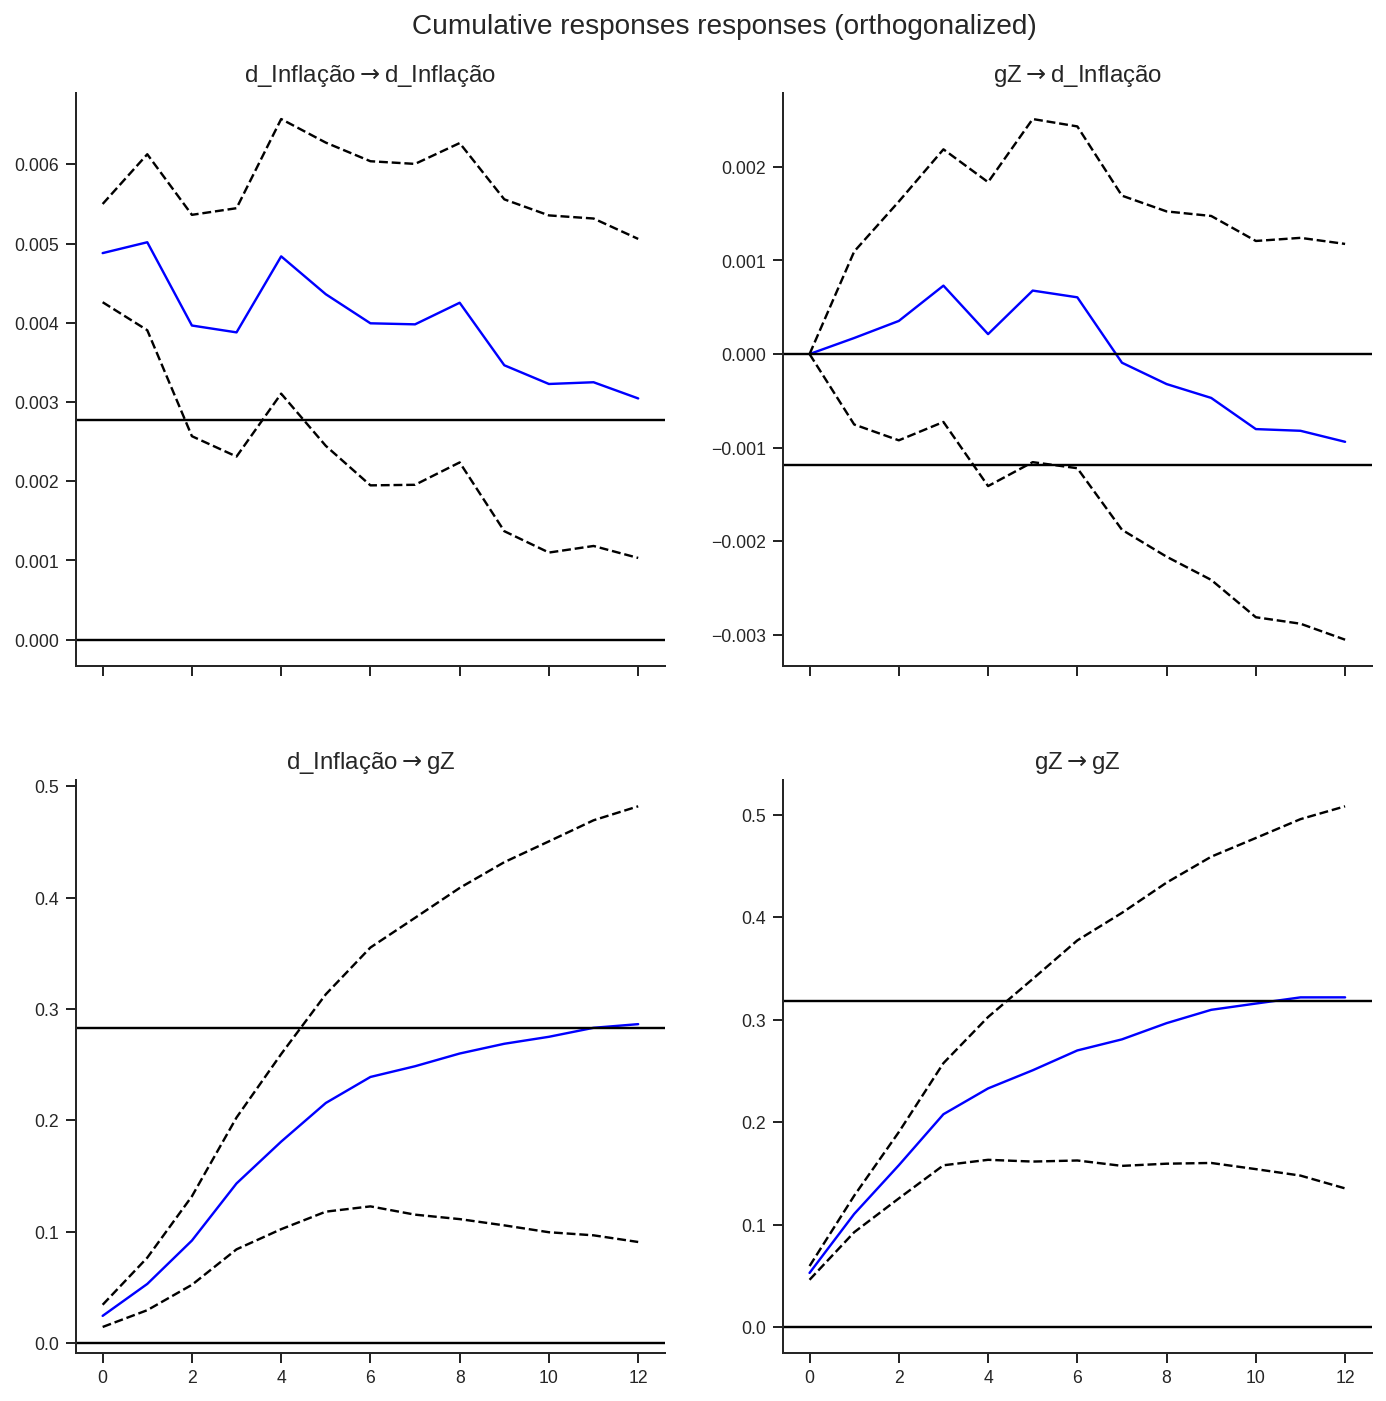

In [41]:
p = results.irf(12).plot_cum_effects(orth=True)
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Cum.png", dpi = 300)

## Decomposição da variância

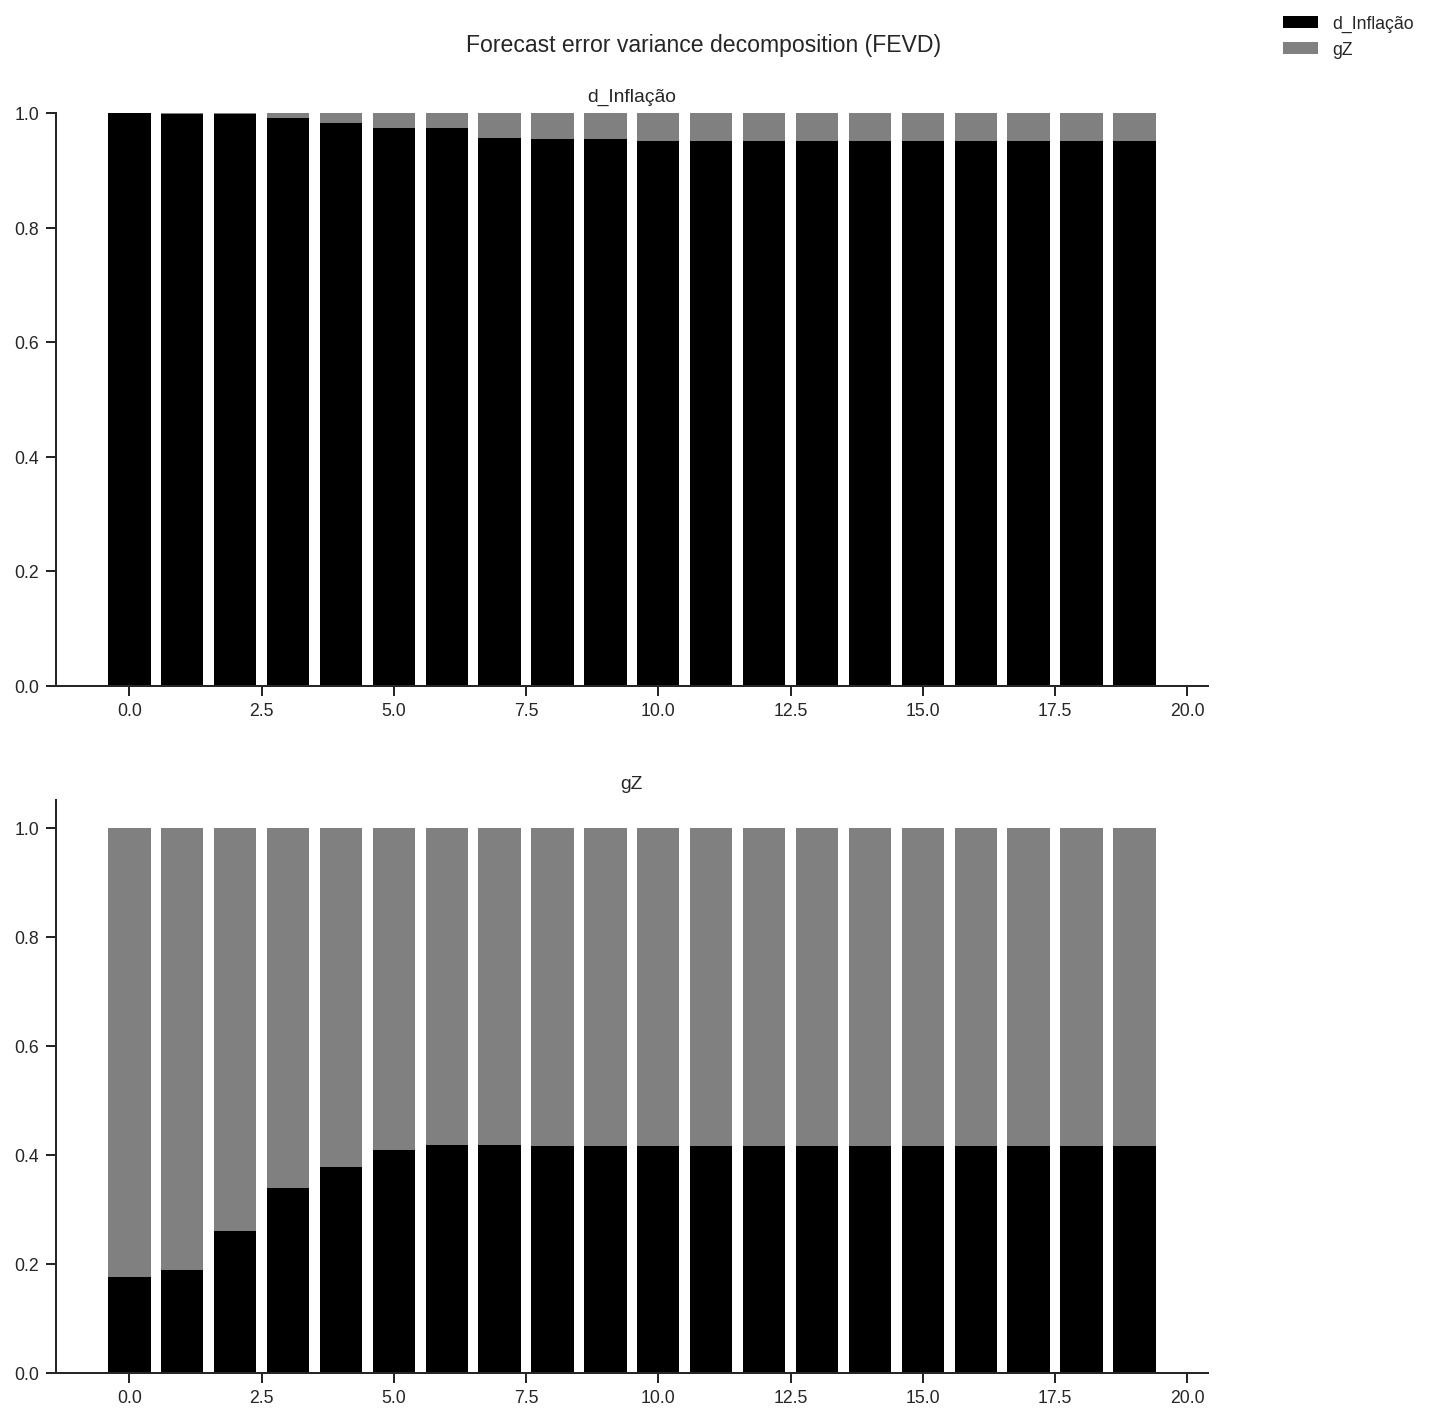

In [42]:
p = results.fevd(20).plot()
sns.despine()
plt.show()
p.savefig("./figs/DecompVar.png", dpi = 300)